*by Wong Shen Nan*

This notebook is written as part of the submission for Artificial Intelligence Apprentice Programme (Batch 13), under AISG. 


## Objective
The objective is to conduct an EDA to predict the occurrence of car failure using the provided dataset for an automotive company to formulate mitigative policies, and evaluate at least 3 suitable models for predicting this occurrence.


## Dataset
The dataset contains the specifications of the cars as well as parameters measured by the car sensors. 

# Setup
Install the necessary dependencies and load them into the current environment.

In [5]:
%pip install pandas seaborn matplotlib numpy lazypredict sklearn IPython lightgbm catboost

Note: you may need to restart the kernel to use updated packages.


In [6]:
# linear algebra
import numpy as np 

# data processing
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'

# data visualization
import seaborn as sns
%matplotlib inline
from matplotlib import pyplot as plt
from matplotlib import style

# sql
import sqlite3 as sql

In [7]:
import warnings

# suppress warnings in cells
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

Use the in-built `sqlite3` module to load the database into the working environment.

In [8]:
# Create a SQL connection to our SQLite database
con = sql.connect('./data/failure.db')
df = pd.read_sql_query('SELECT * FROM failure;', con)

# Be sure to close the connection
con.close()

# Broad Strategy
The aim is to identify factors that contribute greatly to the occurrence of car failure. Understanding the key contributing factors can help the company determine which trait ("features") to arrest in their prognosis to formulate mitigative policies.

We will first begin exploring the data through visualization and analysis of the datatypes and shape. 


## Exploratory Data Analysis

  0. **Data Cleaning**
      - Null imputation
      - Duplicate Removal


  1. **Data Analysis and Visualization**

    Analyse data in general (understanding the dataset) 
    
    - We will have a broad overview of the data provided and make intuitive assumptions about the potential causality of each feature.


  2. **Feature Engineering**
    - Feature extraction
    - Scaling / Transformation / Categorisation
    - VIF / Correlation plot


3. **Build Model**

    We will attempt to apply various ML models and assess their relative performance, then evaluate and optimize the hyperparameters.
  - Baseline Model
  - Hyperparameters
  - Grid Search with Cross-Validation


4. **Model Evaluation**
  - Model metrics plot
  - Confusion matrix
  - ROC plot
  
  
5. **Feature Importance**
  - Feature Importance
  - Recomputation




## Data Overview
We will investigate the shape of the data in broad.

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10081 entries, 0 to 10080
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Car ID            10081 non-null  object 
 1   Model             10081 non-null  object 
 2   Color             10081 non-null  object 
 3   Temperature       10081 non-null  object 
 4   RPM               10081 non-null  int64  
 5   Factory           10081 non-null  object 
 6   Usage             10081 non-null  object 
 7   Fuel consumption  10081 non-null  float64
 8   Membership        9697 non-null   object 
 9   Failure A         10081 non-null  int64  
 10  Failure B         10081 non-null  int64  
 11  Failure C         10081 non-null  int64  
 12  Failure D         10081 non-null  int64  
 13  Failure E         10081 non-null  int64  
dtypes: float64(1), int64(6), object(7)
memory usage: 1.1+ MB


There are 10, 081 samples and 9 features, with the target variables ("Failure X"). 7 of the above features are `object` type, with the rest being `floats` or `ints`. The breakdown of the features follows after exploratory analysis of the features in detail.

Upon cursory evaluation, there are missing values we might need to impute in the `Membership` column. We will do this imputation later.

In [10]:
# get count of unique values to determine range
df.nunique()

Car ID              10000
Model                  41
Color                   5
Temperature           125
RPM                  1114
Factory                 6
Usage                   3
Fuel consumption     2198
Membership              3
Failure A               2
Failure B               2
Failure C               2
Failure D               2
Failure E               2
dtype: int64

We can see clearly that while there were 10,081 samples, there are only 10,000 unique IDs, indicating that there might be duplicates within the dataset. 

Even though there are only 3 listed model categories, we could find 41 different variations, indicating that there might be `string` parsing required of the data. 

All failure variables have binary values, which is what we want.

In [11]:
df.columns.to_list()

['Car ID',
 'Model',
 'Color',
 'Temperature',
 'RPM',
 'Factory',
 'Usage',
 'Fuel consumption',
 'Membership',
 'Failure A',
 'Failure B',
 'Failure C',
 'Failure D',
 'Failure E']

## Column Schema

The features/attributes we are predicting are:

1. Model: 

  Model {3,5,7} of increasing specifications. These are also appended with the year of manufacture, and comes up to about 41 different combinations, which we will need to split out later.
  

2. Color: 
  
  Color of the car. There are five different colors as categorised, Blue, Black, Grey, White and Red.


3. Temperature: 
  
  The average 30day temperature of the car engine before detection of failure. car’s engine needs to reach an optimum temperature in order to run correctly. There would be a need to rescale given that there are some values in Celsius and some in Fahrenheit. For the purposes of evaluation, we will choose Celsius as the standard measure.


4. RPM: 

  Average 30 days maximum torque speed at maximum torque before failure detected. From research, we know that the higher the RPM, the more torque an engine can produce. 


5. Factory: 

  Manufacturing origin of the car. We can see, briefly, that the origin is labelled as `City`, `Country` in that order.


6. Usage: 

Owner usage frequency of the car. We don't have an objective definition of what constitutes `Medium` or `High`, but it is not critical in our analysis given that these are the only values within that variable. 


7. Membership

The types of membership dictate the frequency of checks the subscriber is likely to pursue, given that increasing premiums warrant more car servicing per year.


Lastly, given that there are five indicative status for failure, we might need to do a multi-class classification.

# 0. Data Cleaning

## Duplicates
Car ID is used to identify the unique car data evaluated. No particular relevance in our analysis, but we will need to check if there are duplicated data.

In [12]:
# might drop car Id, not relevant
# but check for duplicates just in case
df.duplicated(subset=['Car ID'], keep='first').sum()

81

In [13]:
ids = df['Car ID']
df[ids.isin(ids[ids.duplicated()])].sort_values('Car ID')

,Car ID,Model,Color,Temperature,RPM,Factory,Usage,Fuel consumption,Membership,Failure A,Failure B,Failure C,Failure D,Failure E
10046,05fc6931-1619-4077-976e-26caf0f7ddab,"Model 5, 2013",Black,231.1 °F,-1679,"New York, U.S",High,697.9,Normal,0,0,0,0,0
66,05fc6931-1619-4077-976e-26caf0f7ddab,"Model 5, 2013",Black,231.1 °F,-1679,"New York, U.S",High,697.9,Normal,0,0,0,0,0
10078,0b9c5542-e343-4b7e-a4c9-aad358dbe993,"Model 3, 2019",White,110.6 °C,1529,"Shang Hai, China",Low,651.5,Normal,0,0,0,0,0
98,0b9c5542-e343-4b7e-a4c9-aad358dbe993,"Model 3, 2019",White,110.6 °C,1529,"Shang Hai, China",Low,651.5,Normal,0,0,0,0,0
10006,0d510f67-2238-4de0-9ac9-1e5a8e345622,"Model 3, 2018",Red,110.7 °C,1512,"Berlin, Germany",Low,601.2,Premium,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60,f5d387f3-b41f-457a-9ae8-1f77e3eafbcb,"Model 3, 2014",White,110.6 °C,1393,"Berlin, Germany",Low,614.8,Normal,0,0,0,0,0
20,fb6b1d49-ed23-42f2-8e39-292e568f517d,"Model 7, 2019",White,110.6 °C,1375,"Shang Hai, China",High,753.5,Normal,0,0,0,0,0
10000,fb6b1d49-ed23-42f2-8e39-292e568f517d,"Model 7, 2019",White,110.6 °C,1375,"Shang Hai, China",High,753.5,Normal,0,0,0,0,0
99,fd5ac6de-3afb-4ad8-b4a9-4bc47b34dd08,"Model 3, 2019",Blue,110.6 °C,1523,"Berlin, Germany",High,638.8,Premium,0,0,0,0,0


We see that there are 81 duplicates, and will thus remove them with the `Car ID` as index.

In [14]:
df.drop_duplicates(inplace=True)
df.drop('Car ID', axis=1, inplace=True)

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 0 to 9999
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Model             10000 non-null  object 
 1   Color             10000 non-null  object 
 2   Temperature       10000 non-null  object 
 3   RPM               10000 non-null  int64  
 4   Factory           10000 non-null  object 
 5   Usage             10000 non-null  object 
 6   Fuel consumption  10000 non-null  float64
 7   Membership        9617 non-null   object 
 8   Failure A         10000 non-null  int64  
 9   Failure B         10000 non-null  int64  
 10  Failure C         10000 non-null  int64  
 11  Failure D         10000 non-null  int64  
 12  Failure E         10000 non-null  int64  
dtypes: float64(1), int64(6), object(6)
memory usage: 1.1+ MB


The data is now reduced to 10,000 unique entries, indexed by `Car ID`. We will now be moving on to null values.

## Null Imputation

For null values, there are two strategies we can typically lean towards:

1. We can use the `mean`, `median` or `mode` values to impute.
2. We canelect random values from the feature to replace missing values.

In [16]:
total = df.isnull().sum().sort_values(ascending=False)

proportion = df.isnull().sum() / df.isnull().count() * 100
proportion_sorted = (round(proportion, 1)).sort_values(ascending=False)

missing = pd.concat([total, proportion_sorted], axis=1, keys=['Total', '%'])
missing.head()

,Total,%
Membership,383,3.8
Model,0,0.0
Color,0,0.0
Temperature,0,0.0
RPM,0,0.0


<AxesSubplot: >

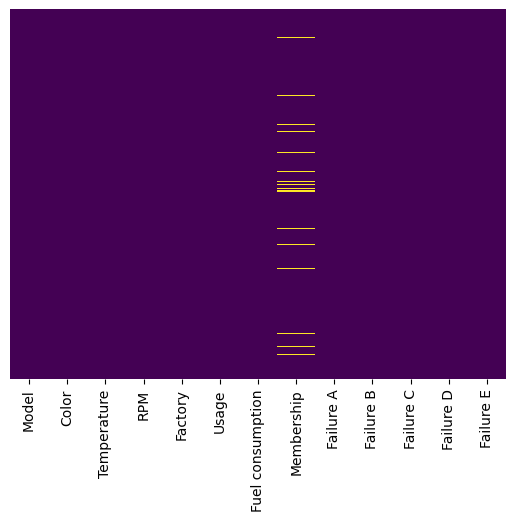

In [17]:
sns.heatmap(df.isnull(), yticklabels=False, cbar=False, cmap='viridis')

`Membership` has ~384 values missing, but since it's a small proportion (around 4%) we can still attempt to impute it later using their cars' year of purchase. The rest have no missing values, so we can focus on `Membership` first.



In [18]:
# membership
df['Membership'].unique()

array(['Normal', 'Premium', None, 'None'], dtype=object)

We can see from the values that there are both `None` (null type) and `'None'` (object type). We would need to:

1. Assume that the stringified 'None' implies that the car owner has either deliberately revoked their membership, or has expired. 

2. For missing values, will need to impute from the year of purchase, under the listed condition (*Car owners are automatically subscribed with “Normal” membership for the first five years after car purchase.*)

We can first check if there is a correlation between the two types.

In [19]:
# split model to [model, year]
df[['Model Name', 'Model Year']] = df['Model'].str.split(',', expand=True)
df[['Model Name', 'Model Year']].describe()

,Model Name,Model Year
count,10000,10000
unique,3,14
top,Model 3,2016
freq,6000,971


In [20]:
# before fill_na with 'None', check year and impute membership status given year of purchase
df['Model Year'].loc[df['Membership'].isnull()].value_counts()

 2018    88
 2020    80
 2019    78
 2021    74
 2022    63
Name: Model Year, dtype: int64

We can see clearly that all the `null` values are co-located within **FIVE** years of the purchase of the car, thus we can proceed with imputing the missing values with a default `Normal` membership.

In [21]:
def hasNormalMembership(row, current=2023):
  membership_tenure = current - int(row['Model Year'])
  return membership_tenure <=5

df['Membership'] = df.apply(
    lambda row: 'Normal' if row['Membership'] is None and hasNormalMembership(row) else row['Membership'],
    axis=1
)

# check for any more null value
df['Membership'].isnull().sum()

0

# 1. Data Analysis and Visualisation

## Target Variable: Failure(s)

As our goal is to predict likelihood of failure, be it any one of the five listed failures, we need to first assess the suitability of the feature for prediction and analyse against other feature variables.

In [22]:
# are there rows with more than one failure

df.iloc[:, -7:-2].sum(axis=1).unique()

array([0, 1])


For the purpose of easier comparison, we can engineer a new column called `Failure` to encompass any failure markers. i.e. as long as one of the failures register, there will be a nett failure registered for this row.

In [23]:
# create new column that contains the label of the failure of that row
failure_df = df.filter(like='Failure')

failure_df = failure_df.where(failure_df == 1, False)
failure_df = failure_df.where(failure_df == 0, True)

failure_df = failure_df.apply(pd.to_numeric)
df['Failure Type'] = ''

for index, row in failure_df.iterrows():
    if not row.any():
        df.at[index, 'Failure Type'] = 'None'
    else:
        target = row.idxmax()
        df.at[index, 'Failure Type'] = target.split(' ')[1].strip()

In [24]:
df.head()

,Model,Color,Temperature,RPM,Factory,Usage,Fuel consumption,Membership,Failure A,Failure B,Failure C,Failure D,Failure E,Model Name,Model Year,Failure Type
0,"Model 5, 2022",Blue,110.3 °C,1551,"Shang Hai, China",Medium,659.7,Normal,0,0,0,0,0,Model 5,2022,None
1,"Model 3, 2022",Black,110.4 °C,1408,"Shang Hai, China",Medium,705.3,Premium,1,0,0,0,0,Model 3,2022,A
2,"Model 3, 2022",Grey,110.3 °C,1498,"Shang Hai, China",Low,670.7,Premium,0,0,0,0,0,Model 3,2022,None
3,"Model 3, 2022",Black,110.4 °C,1433,"Berlin, Germany",High,630.6,Premium,1,0,0,0,0,Model 3,2022,A
4,"Model 3, 2022",White,230.7 °C,1408,"New York, U.S",High,660.9,Normal,0,1,0,0,0,Model 3,2022,B


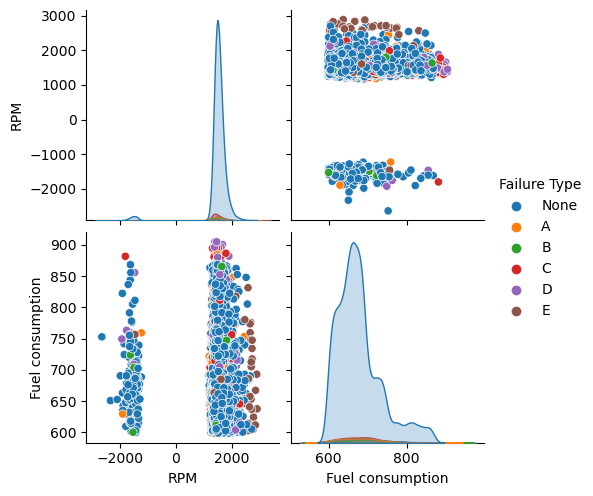

In [25]:
failure_list = failure_df.columns.to_list()
no_failure_df = df[df.columns[~df.columns.isin(failure_list)]]

sns.pairplot(no_failure_df, hue="Failure Type")

We can see a weird distribution of RPM values (negative and positive). We will come back to this later in our analysis.

<AxesSubplot: xlabel='Failure Type', ylabel='count'>

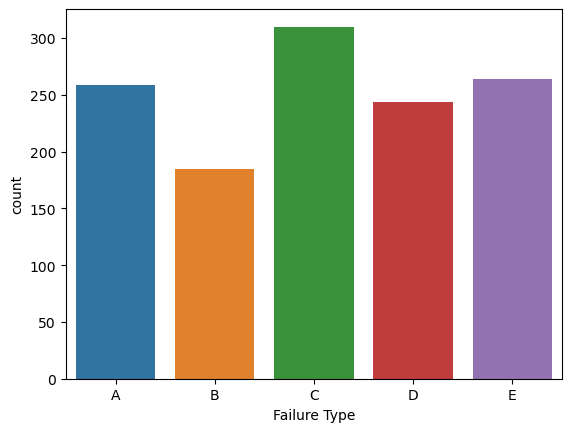

In [26]:
sns.countplot(data=df[-(df['Failure Type'] == 'None')], x='Failure Type')

There seems to be a fair distribution of failures across the different failure types, with `C` registering the highest count, and `B` registering the lowest.

## Feature Variable: Membership (Ordinal)

There are three `membership` tiers of increasing benefits, `None` for no free servicing, `Normal` for one that offers subscribers two complimentary car servicing a year and `Premium` that offers unlimited car servicing. While these are the benefits assigned to each membership, we can assume that subscribers who take up any membership will use the benefits to its entirety, i.e. if someone owns a `Normal` membership, he/she will visit the car servicing centre for only two times a year.

<AxesSubplot: ylabel='Membership'>

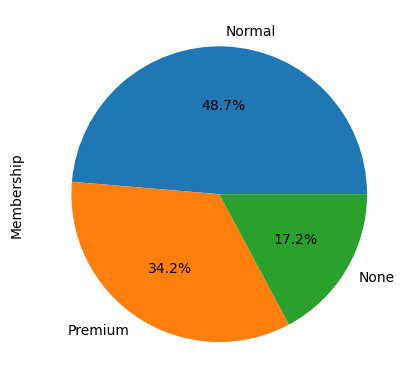

In [27]:
df['Membership'].value_counts().plot(kind='pie', autopct='%1.1f%%')

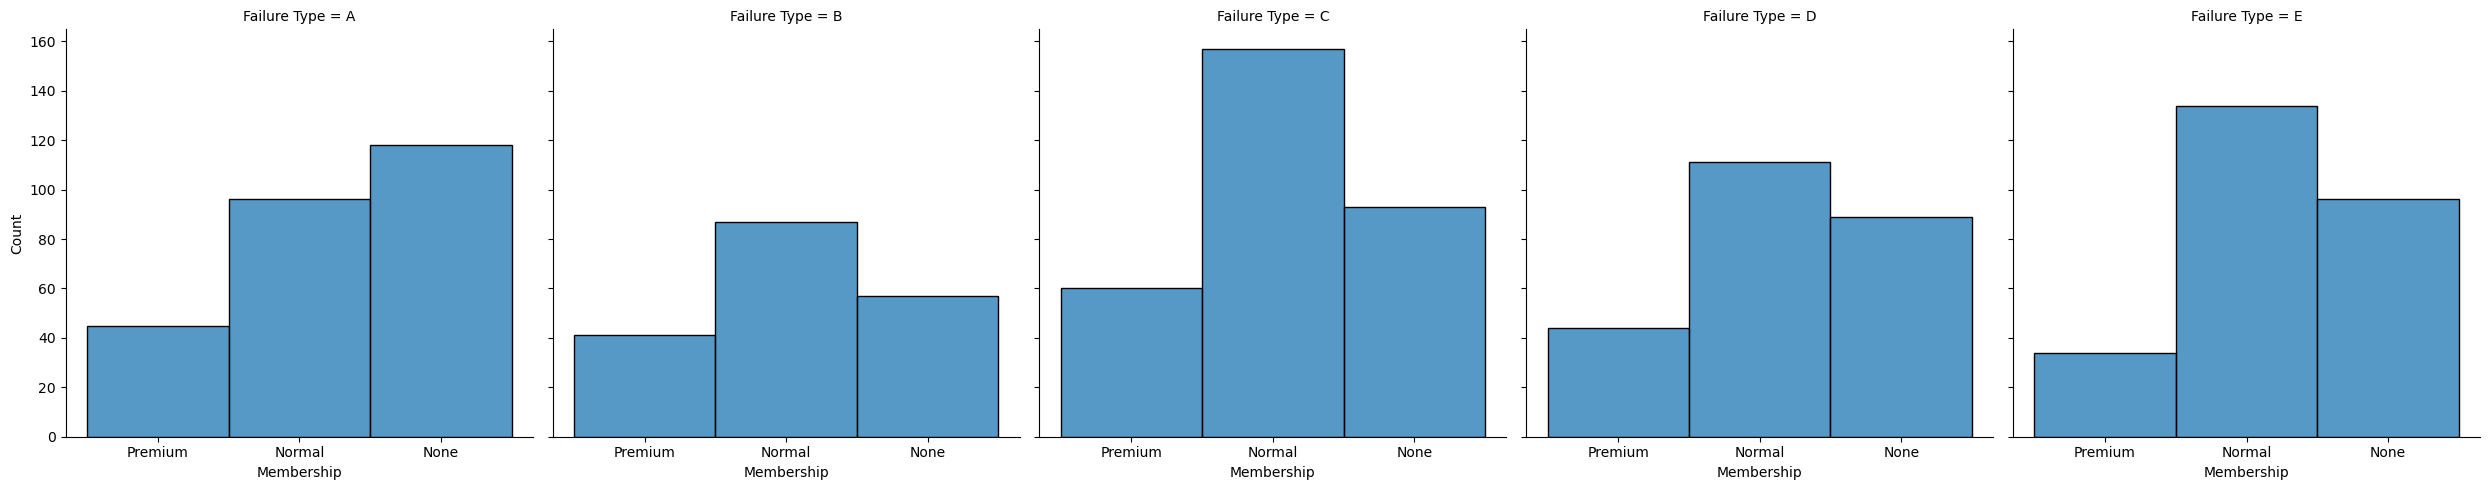

In [28]:
# compare against failure
fg = sns.displot(
    data=df[-(df['Failure Type'] == 'None')], 
    x='Membership',
    col='Failure Type')

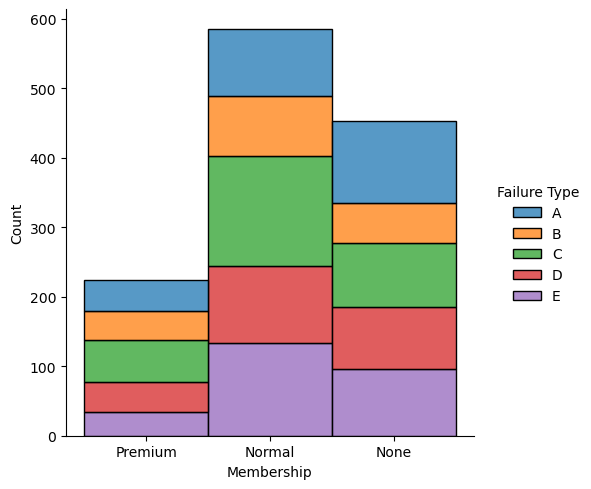

In [29]:
fg = sns.displot(
    data=df[-(df['Failure Type'] == 'None')], 
    x='Membership',
    hue='Failure Type',
    multiple="stack"
)

We can see clearly that `Premium` members generally suffer a lesser incidence of failures across the board in absolute figures. If we stack up against each membership, we can see that while `Normal` members have two complimentary car servicing, it does not seem to matter since there is a higher incidence of failures than those without.

## Feature Variable: Model (Ordinal)

In [30]:
# for a refresher
df[['Model']].describe()

,Model
count,10000
unique,41
top,"Model 3, 2016"
freq,586


Since we've previously split `Model` into its constituent `Model Name` and `Model Year`, we can proceed to assess these values.

In [31]:
models = df['Model Name'].unique()
print(models)

['Model 5' 'Model 3' 'Model 7']


<AxesSubplot: ylabel='Model Name'>

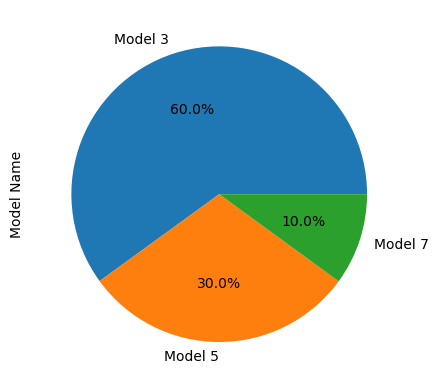

In [32]:
df['Model Name'].value_counts().plot(kind='pie', autopct='%1.1f%%')

We have a large majority using the `Model 3` (60%) as their daily drive, followed by `Model 5` (30%) and `Model 7` (10%). This distribution could be largely based on the relative cost of purchase, given that increasing specifications of cars typically result in increasing prices. 

In [33]:
df['Model Year']

0        2022
1        2022
2        2022
3        2022
4        2022
        ...  
9995     2021
9996     2021
9997     2021
9998     2021
9999     2020
Name: Model Year, Length: 10000, dtype: object

While the `Model Year` is indicative of the year of purchase, it is not useful in this scenario since we can't make use of it in its current form to make any analysis. We could cast it to reflect its years in service to give a better sense of the relative degree of usage in years.

In [34]:
df['Years in service'] = 2023 - df['Model Year'].astype('int')
df['Years in service'].unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14])

In [35]:
ct = (
    pd.crosstab(
        df['Years in service'],
        df['Failure Type'],
        margins=True,
      )
)

ct.style.background_gradient(cmap='YlOrRd')

Failure Type,A,B,C,D,E,None,All
Years in service,,,,,,,
1,17,13,15,11,23,466,545
2,18,16,17,21,23,794,889
3,12,21,30,17,18,864,962
4,19,13,28,16,21,769,866
5,12,18,33,18,27,842,950
6,13,18,33,11,23,766,864
7,20,16,32,21,32,850,971
8,19,15,31,23,23,752,863
9,16,21,29,15,25,838,944


Seems to be an increase in `Failures A and D` as the years in service increases, whereas the other `failures` tend to stay relatively stable.

<AxesSubplot: xlabel='Model Name', ylabel='Years in service'>

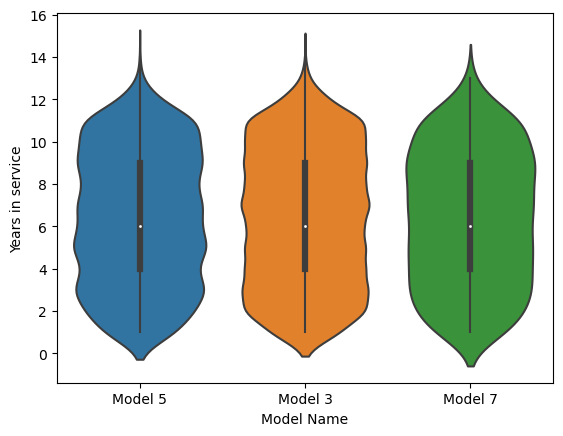

In [36]:
sns.violinplot(x='Model Name', y='Years in service', data=df)

Model 7 seems to have a more vehicles that are fresh off the manufacturing line.

## Feature Variable: Color (Categorical)

<AxesSubplot: ylabel='Color'>

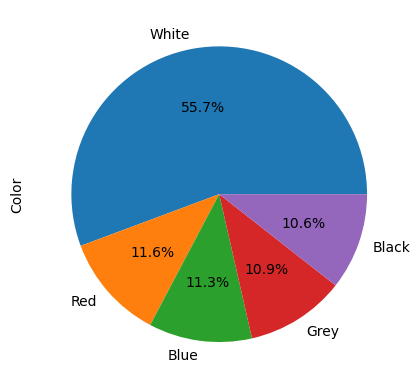

In [37]:
# color
df['Color'].value_counts().plot(kind='pie', autopct='%1.1f%%')

In [38]:
df['Color'].describe()

count     10000
unique        5
top       White
freq       5568
Name: Color, dtype: object

There is a strong majority (55%) of cars which are `white` in color, and a relatively even distribution across the other colors (~11%). We can also look at the distribution of colors with respect to `Model Name` to get a beter understanding of the relative purchasing patterns.

In [39]:
ct = (
    pd.crosstab(
        df['Color'],
        df['Model Name'],
        margins=True,
      )
)

ct.style.background_gradient(cmap='YlOrRd')

Model Name,Model 3,Model 5,Model 7,All
Color,,,,
Black,645,308,105,1058
Blue,652,367,110,1129
Grey,652,318,116,1086
Red,693,350,116,1159
White,3358,1654,556,5568
All,6000,2997,1003,10000


Color distribution across the different makes reflect the same trends as previously described, with `White` as the clear majority.

In [40]:
ct = (
    pd.crosstab(
        df['Color'],
        df['Failure Type'],
        margins=True,
      )
)

ct.style.background_gradient(cmap='YlOrRd')

Failure Type,A,B,C,D,E,None,All
Color,,,,,,,
Black,28,26,30,28,24,922,1058
Blue,21,20,32,21,32,1003,1129
Grey,26,16,39,31,38,936,1086
Red,34,16,32,35,32,1010,1159
White,150,107,177,129,138,4867,5568
All,259,185,310,244,264,8738,10000


In [41]:
(
    pd.crosstab(
        df['Color'],
        df['Failure Type'],
        margins=True,
        normalize='index'
      ).round(4)*100
)


Failure Type,A,B,C,D,E,None
Color,,,,,,
Black,2.65,2.46,2.84,2.65,2.27,87.15
Blue,1.86,1.77,2.83,1.86,2.83,88.84
Grey,2.39,1.47,3.59,2.85,3.50,86.19
Red,2.93,1.38,2.76,3.02,2.76,87.14
White,2.69,1.92,3.18,2.32,2.48,87.41
All,2.59,1.85,3.10,2.44,2.64,87.38


No clear indication of trend / pattern for `Failure Types` against `Colors`.

## Feature Variable: Temperature (Ratio)

Earlier we recognised that there are different temperature units (`C` and `F`), hence we will need to scale it accordingly. We will first separate the number and the unit for easier parsing.

In [42]:
# split Temperature variable into its constituent value and units
df[['Temp', 'Temp Unit']] = df['Temperature'].str.split(' ', expand=True)
df['Temp'] = df['Temp'].astype('float')

df[['Temp','Temp Unit']].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 0 to 9999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Temp       10000 non-null  float64
 1   Temp Unit  10000 non-null  object 
dtypes: float64(1), object(1)
memory usage: 492.4+ KB


In [43]:
df['Temp Unit'].unique()

array(['°C', '°F'], dtype=object)

In [44]:
# convert all °F values to celcius
df['Temp Unit'].value_counts()

°C    7830
°F    2170
Name: Temp Unit, dtype: int64

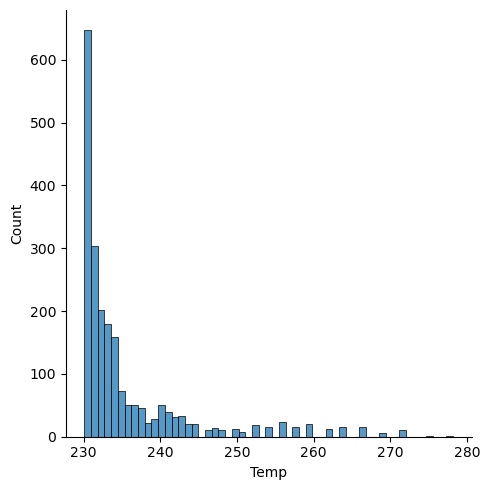

In [45]:
import seaborn as sns

# isolate data with Fahrenheit units
temp_df = df.loc[df['Temp Unit'] == '°F'].sort_values(by='Temp')
temp_grid = sns.displot(data=temp_df, x='Temp')

There are 2193 fahrenheit values that we would need to convert, with a distribution of 230F and 280F (around 110 to 137), a reasonable range.

In [46]:
def fahrenheitToCelsius(f)-> float:
  return (f - 32) * 5.0/9.0

df['Temp'] = df[['Temp','Temp Unit']].apply(lambda x: fahrenheitToCelsius(x['Temp']) if x['Temp Unit'] == '°F' else x['Temp'], axis=1)

<AxesSubplot: >

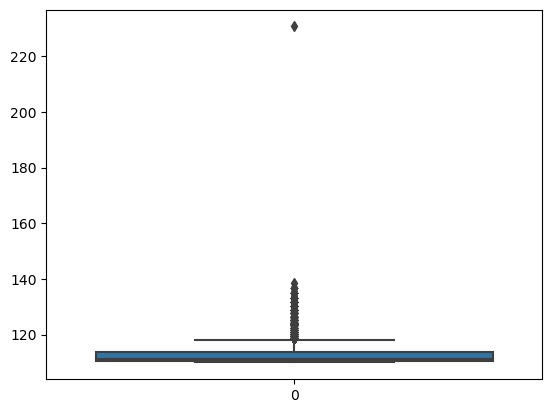

In [47]:
# check for outliers
sns.boxplot(df['Temp'])

There seems to be an outlier in the 230 range.

In [48]:
df['Temp'].describe()

count    10000.000000
mean       113.118548
std          4.670704
min        110.000000
25%        110.400000
50%        111.400000
75%        113.600000
max        230.700000
Name: Temp, dtype: float64

In [49]:
df[df['Temp'] > 160]

,Model,Color,Temperature,RPM,Factory,Usage,Fuel consumption,Membership,Failure A,Failure B,Failure C,Failure D,Failure E,Model Name,Model Year,Failure Type,Years in service,Temp,Temp Unit
4,"Model 3, 2022",White,230.7 °C,1408,"New York, U.S",High,660.9,Normal,0,1,0,0,0,Model 3,2022,B,1,230.7,°C


We have an input that was wrongly classified. As this car was manufactured in the US, we can safely assume that it was incorrectly labelled with a C unit even though it's a fahrenheit value.

We will thus convert the value to a celsius unit.

In [50]:
df['Temp'] = df['Temp'].apply(lambda temp: fahrenheitToCelsius(temp) if temp > 160 else temp)

df['Temp'].describe()

count    10000.000000
mean       113.106517
std          4.520331
min        110.000000
25%        110.400000
50%        111.400000
75%        113.600000
max        138.700000
Name: Temp, dtype: float64

In [51]:
df.drop(['Temperature','Temp Unit'], axis=1, inplace=True)
df.head()

,Model,Color,RPM,Factory,Usage,Fuel consumption,Membership,Failure A,Failure B,Failure C,Failure D,Failure E,Model Name,Model Year,Failure Type,Years in service,Temp
0,"Model 5, 2022",Blue,1551,"Shang Hai, China",Medium,659.7,Normal,0,0,0,0,0,Model 5,2022,None,1,110.300000
1,"Model 3, 2022",Black,1408,"Shang Hai, China",Medium,705.3,Premium,1,0,0,0,0,Model 3,2022,A,1,110.400000
2,"Model 3, 2022",Grey,1498,"Shang Hai, China",Low,670.7,Premium,0,0,0,0,0,Model 3,2022,None,1,110.300000
3,"Model 3, 2022",Black,1433,"Berlin, Germany",High,630.6,Premium,1,0,0,0,0,Model 3,2022,A,1,110.400000
4,"Model 3, 2022",White,1408,"New York, U.S",High,660.9,Normal,0,1,0,0,0,Model 3,2022,B,1,110.388889


<AxesSubplot: xlabel='Temp'>

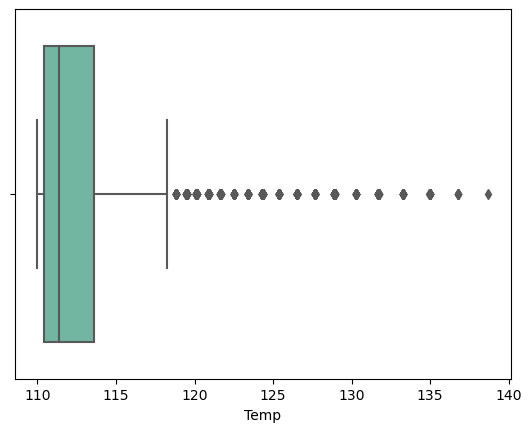

In [52]:
sns.boxplot(df, x='Temp', orient="h", palette="Set2")

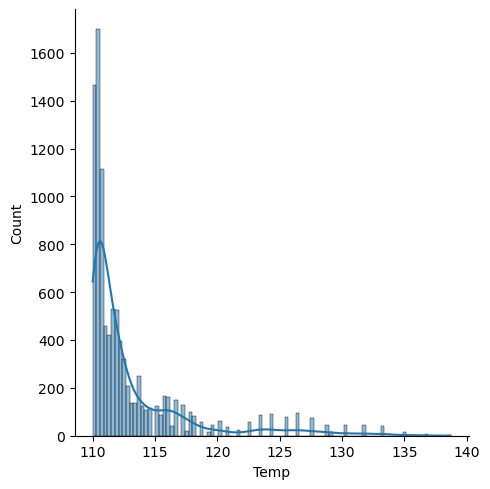

In [53]:
sns.displot(df, x='Temp', kde=True)

There is a clear right skewed distribution of data, which we will tend to later. The temperatures are congregated around the `110` to `112` range.

## Feature Variable: RPM (Ratio)

In [54]:
df['RPM'].describe()

count    10000.000000
mean      1470.970100
std        486.047372
min      -2636.000000
25%       1418.000000
50%       1499.000000
75%       1609.000000
max       2886.000000
Name: RPM, dtype: float64

In [55]:
(df['RPM'] < 0).sum()

220

We identified previously that there were negative values, let's investigate if we can simply inverse its polarity.

In [56]:
df.loc[(df['RPM'] > 0)]['RPM'].describe()

count    9780.000000
mean     1538.725051
std       179.459854
min      1168.000000
25%      1423.000000
50%      1503.000000
75%      1611.250000
max      2886.000000
Name: RPM, dtype: float64

In [57]:
df.loc[(df['RPM'] < 0)]['RPM'].describe()

count     220.000000
mean    -1541.045455
std       171.664794
min     -2636.000000
25%     -1620.250000
50%     -1520.000000
75%     -1429.750000
max     -1227.000000
Name: RPM, dtype: float64

Notice there are about 220 negative values. Since the distribution (`mean` and `std`) are roughly equivalent, we can take the absolute value of the `RPM` variables.

In [58]:
df['RPM'] = df['RPM'].abs()

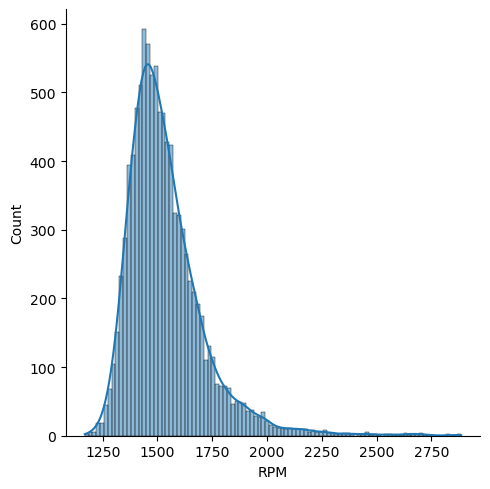

In [59]:
sns.displot(df, x='RPM', kde=True)

In [60]:
df['RPM'].describe()

count    10000.000000
mean      1538.776100
std        179.284096
min       1168.000000
25%       1423.000000
50%       1503.000000
75%       1612.000000
max       2886.000000
Name: RPM, dtype: float64

RPM seems to follow a relatively normal distribution, with a slight right skew, and a mean at `1538.7`

## Feature Variable: Factory (Categorical)

In [61]:
df['Factory'].describe()

count                10000
unique                   6
top       Shang Hai, China
freq                  5478
Name: Factory, dtype: object

We can see that the `Factory` variable consists of the `City` and `Country` of manufacturing origin, which we will strip out for clearer comparison.

In [62]:
df[['City', 'Country']] = df['Factory'].str.split(',', expand=True).apply(lambda x: [e.strip() for e in x])
df[['City','Country']].describe()

,City,Country
count,10000,10000
unique,6,3
top,Shang Hai,China
freq,5478,5628


In [63]:
df['City'].unique()

array(['Shang Hai', 'Berlin', 'New York', 'Seng Kang', 'Newton', 'Bedok'],
      dtype=object)

In [64]:
df['Country'].unique()

array(['China', 'Germany', 'U.S'], dtype=object)

While there are only 3 `countries` (namely US, China and Germany), there are 6 different `cities`, with 3 of them being obvious Singaporean towns (i.e. Seng Kang, Newton, and Bedok). We will investigate the impact of the injection of these Singaporean towns.

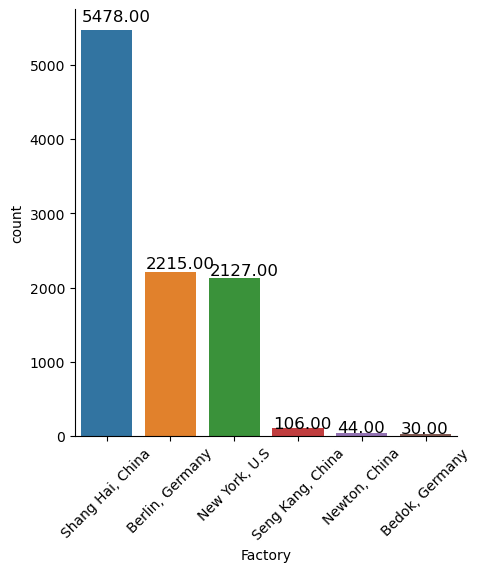

In [65]:
# df[['Factory','Failure']]
import seaborn as sns

grid = sns.catplot(data=df, x='Factory', kind='count')

ax = grid.facet_axis(0,0)
ax.tick_params(axis='x', rotation=45)

for p in ax.patches:
    ax.text(p.get_x() + 0.015, 
            p.get_height() * 1.02, 
            '{0:.2f}'.format(p.get_height()), 
            color='black', rotation='horizontal', size='large')

We can safely assume that the factory data is wrongly labelled (perhaps an autocorrect since the initials for the cities are similar) and group them under the main countries, China, US and Germany. Data mislabelled with Singaporean towns will be subsumed under their presumed parent country, China or Germany.

In [66]:
# drop city
df.drop(['Factory','City'], axis=1)

,Model,Color,RPM,Usage,Fuel consumption,Membership,Failure A,Failure B,Failure C,Failure D,Failure E,Model Name,Model Year,Failure Type,Years in service,Temp,Country
0,"Model 5, 2022",Blue,1551,Medium,659.7,Normal,0,0,0,0,0,Model 5,2022,None,1,110.300000,China
1,"Model 3, 2022",Black,1408,Medium,705.3,Premium,1,0,0,0,0,Model 3,2022,A,1,110.400000,China
2,"Model 3, 2022",Grey,1498,Low,670.7,Premium,0,0,0,0,0,Model 3,2022,None,1,110.300000,China
3,"Model 3, 2022",Black,1433,High,630.6,Premium,1,0,0,0,0,Model 3,2022,A,1,110.400000,Germany
4,"Model 3, 2022",White,1408,High,660.9,Normal,0,1,0,0,0,Model 3,2022,B,1,110.388889,U.S
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,"Model 5, 2021",Black,1604,Medium,684.6,Normal,0,0,0,0,1,Model 5,2021,E,2,110.600000,China
9996,"Model 7, 2021",Grey,1632,Medium,865.4,Normal,0,1,0,0,0,Model 7,2021,B,2,110.600000,China
9997,"Model 5, 2021",White,1645,Low,646.2,Premium,0,0,0,0,0,Model 5,2021,None,2,110.600000,China
9998,"Model 7, 2021",White,1408,High,837.0,Premium,0,0,0,0,0,Model 7,2021,None,2,110.611111,U.S


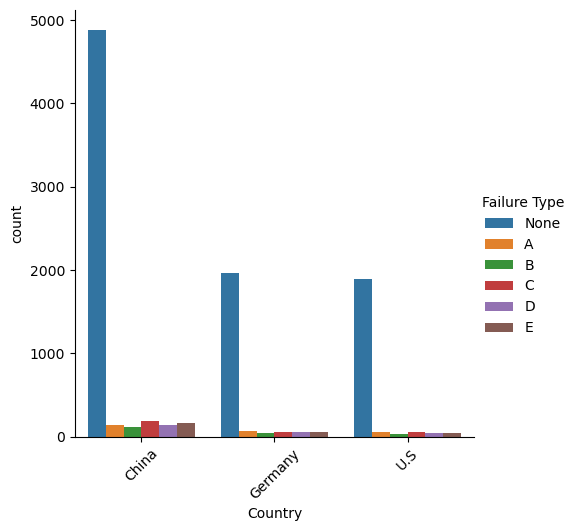

In [67]:
grid = sns.catplot(data=df, x='Country', hue='Failure Type', kind='count')

ax = grid.facet_axis(0,0)
ax.tick_params(axis='x', rotation=45)

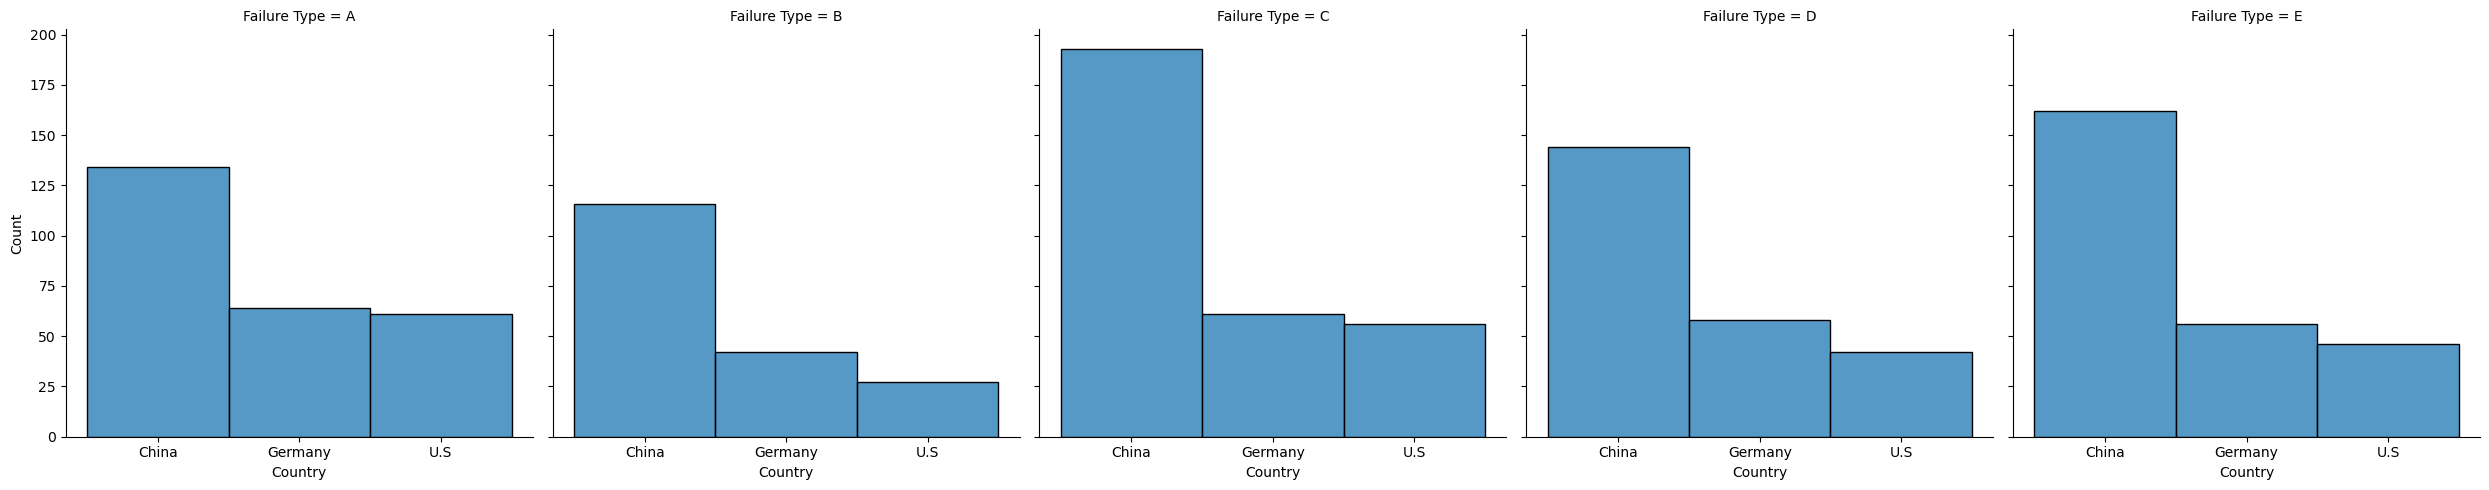

In [68]:
# ignoring none for now
sns.displot(
    data=df[-(df['Failure Type'] == 'None')], 
    x='Country',
    col='Failure Type')

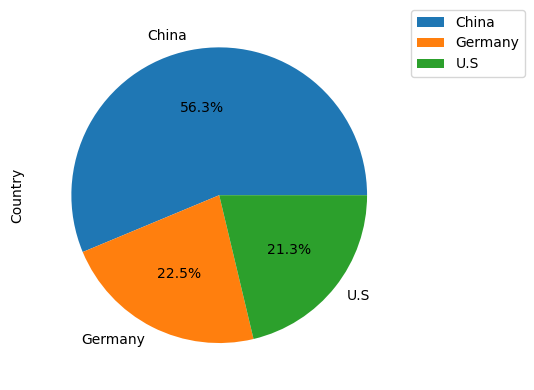

In [69]:
ax = df['Country'].value_counts().plot(kind='pie', autopct='%1.1f%%')
ax.legend(bbox_to_anchor=(1, 1.02), loc='upper left')

The majority (56.3%) of cars are manufactured in China, while U.S and Germany share the rest of the pie equally at around 21%.

## Feature Variable: Usage (Ordinal)

In [70]:
df['Usage'].describe()

count     10000
unique        3
top        High
freq       3527
Name: Usage, dtype: object

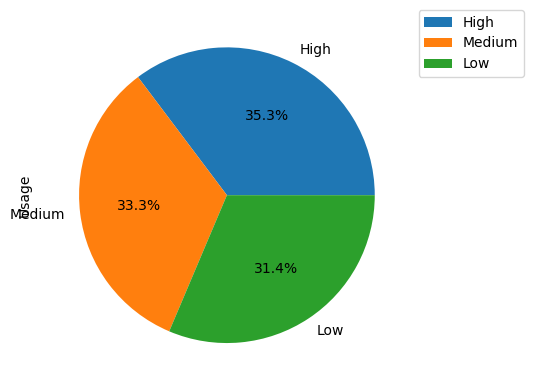

In [71]:
ax = df['Usage'].value_counts().plot(kind='pie', autopct='%1.1f%%')
ax.legend(bbox_to_anchor=(1, 1.02), loc='upper left')

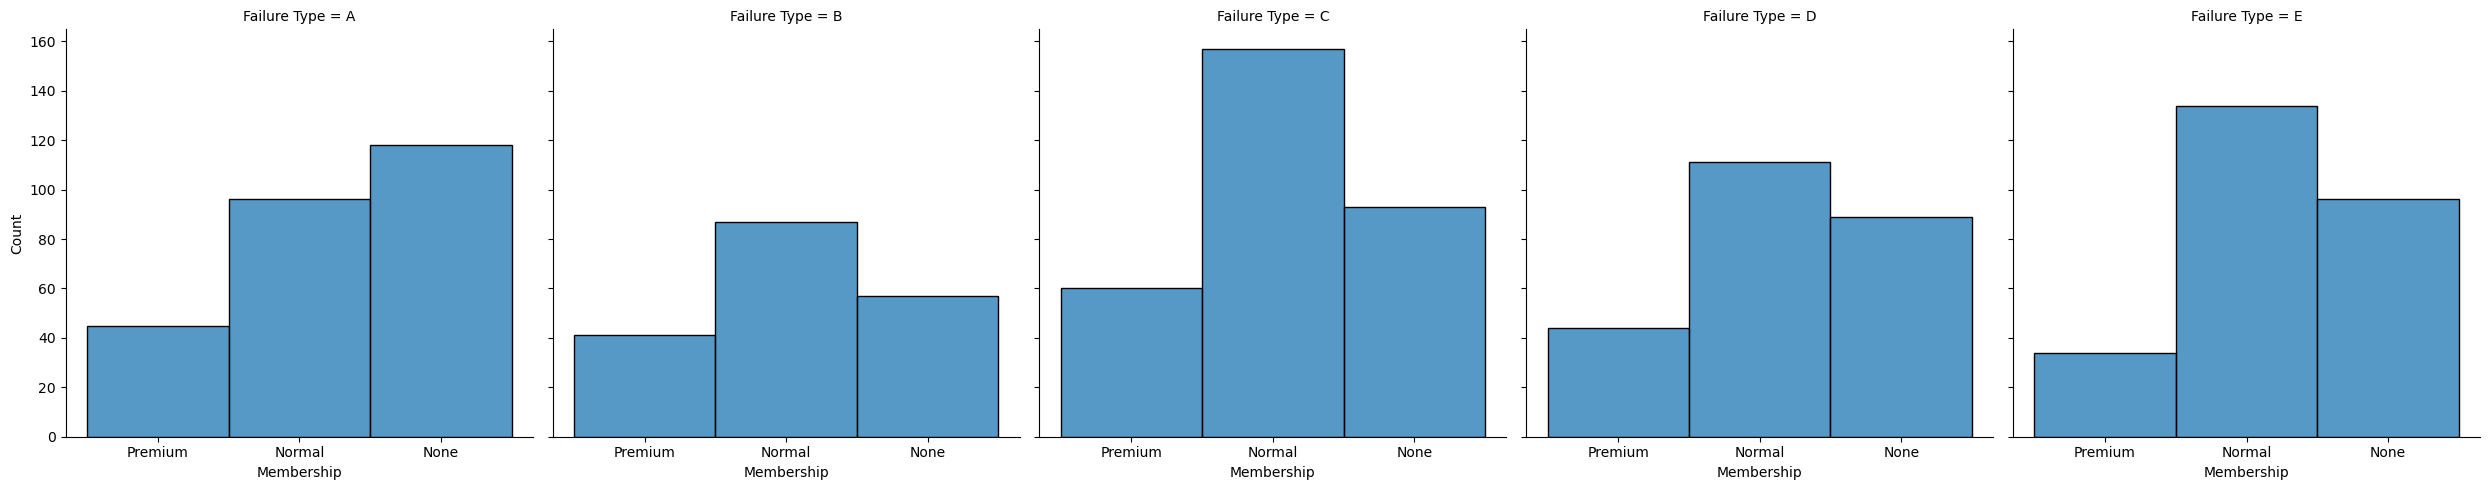

In [72]:
sns.displot(
    data=df[-(df['Failure Type'] == 'None')], 
    x='Membership',
    col='Failure Type')

## Feature Variable: Fuel Consumption (Ratio)

In [73]:
df['Fuel consumption'].describe()

count    10000.000000
mean       679.456990
std         58.439696
min        598.500000
25%        638.875000
50%        668.500000
75%        704.200000
max        904.800000
Name: Fuel consumption, dtype: float64

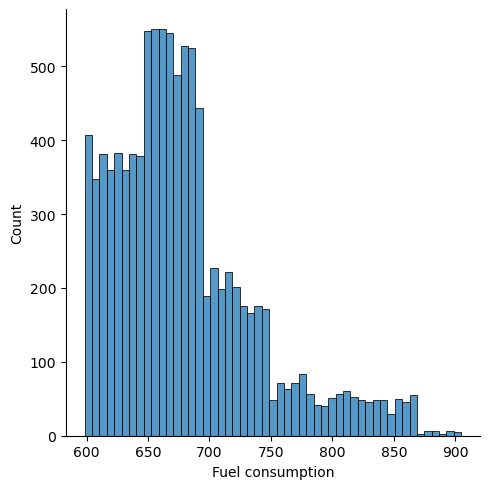

In [74]:
sns.displot(data=df, x='Fuel consumption')

Not much data cleaning required, other than converting the data to L/100km, to improve readability and comply with EU's regulatory standard of measure.

In [75]:
df['Fuel consumption'] = df['Fuel consumption'].apply(lambda fc: float(fc/100))

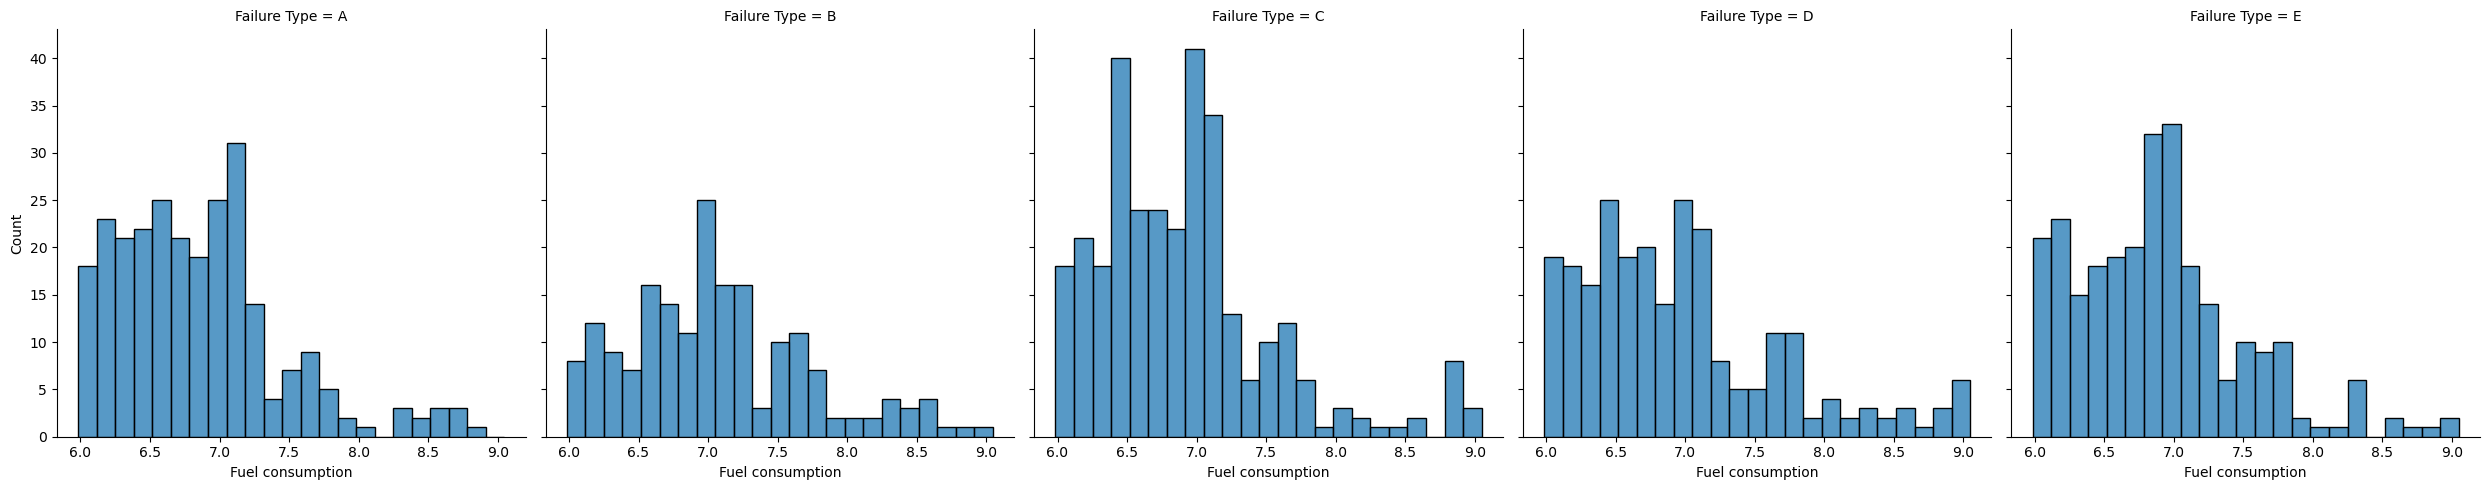

In [76]:
sns.displot(
    data=df[-(df['Failure Type'] == 'None')], 
    x='Fuel consumption',
    col='Failure Type')

<AxesSubplot: xlabel='Fuel consumption', ylabel='Failure Type'>

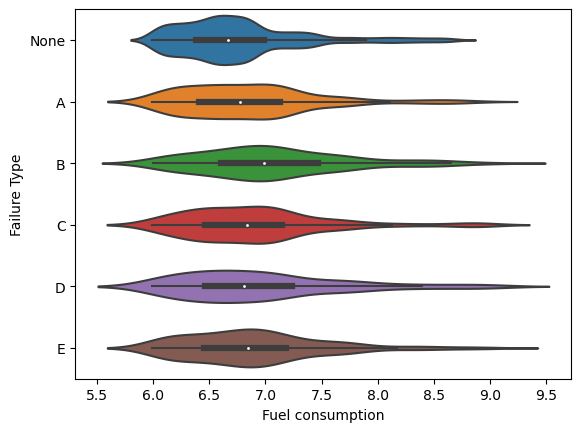

In [77]:
sns.violinplot(x='Fuel consumption', y='Failure Type', data=df)

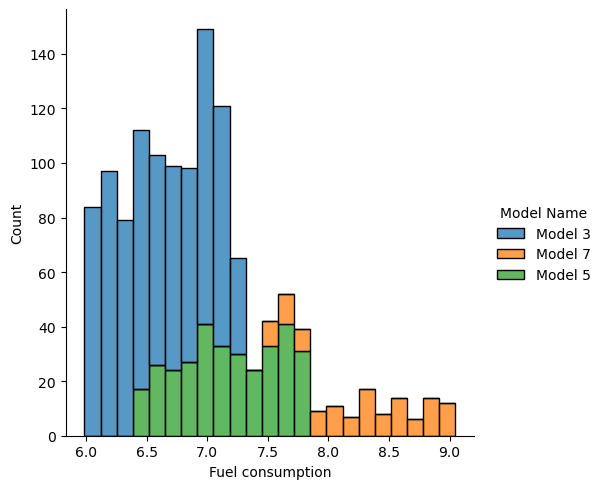

In [78]:
sns.displot(
    data=df[-(df['Failure Type'] == 'None')], 
    x='Fuel consumption',
    hue='Model Name',
    multiple='stack'
)

General failures happen between 6.5L/100KM to 7.2L/100KM, which could simply be the aggregation of vehicles with the capacity within this range. `Failure B` happens relatively further in the region of 7.0L/100KM as compared to the rest of the failures.

In [79]:
df.head()

,Model,Color,RPM,Factory,Usage,Fuel consumption,Membership,Failure A,Failure B,Failure C,Failure D,Failure E,Model Name,Model Year,Failure Type,Years in service,Temp,City,Country
0,"Model 5, 2022",Blue,1551,"Shang Hai, China",Medium,6.597,Normal,0,0,0,0,0,Model 5,2022,None,1,110.300000,Shang Hai,China
1,"Model 3, 2022",Black,1408,"Shang Hai, China",Medium,7.053,Premium,1,0,0,0,0,Model 3,2022,A,1,110.400000,Shang Hai,China
2,"Model 3, 2022",Grey,1498,"Shang Hai, China",Low,6.707,Premium,0,0,0,0,0,Model 3,2022,None,1,110.300000,Shang Hai,China
3,"Model 3, 2022",Black,1433,"Berlin, Germany",High,6.306,Premium,1,0,0,0,0,Model 3,2022,A,1,110.400000,Berlin,Germany
4,"Model 3, 2022",White,1408,"New York, U.S",High,6.609,Normal,0,1,0,0,0,Model 3,2022,B,1,110.388889,New York,U.S


# 2. Feature Engineering

We will adopt the following strategies during feature engineering.

1. For Ordinal variables like `Membership` and `Usage`, where there's a clear progression, we will dummy encode the variables.
     
2. For Categorical variables like `Country` and `Color`, where ordinality does not matter, we will apply label encoding to generate numerical representations. 
    
3. For Continuous variables like `Fuel consumption` and `temperature`, we will need to check if the distribution is Normal, else we will need to apply transformations like `PowerTransfomer` to enforce Gaussian-like distribution.

4. We will then drop redundant features like the original `Model` and `Factory` since they no longer have relevance in our analysis.

5. A correlation matrix will be plotted to check for multi-collinearity between variables, and variables with high collinearity will be pruned.

In [80]:
df.head()

,Model,Color,RPM,Factory,Usage,Fuel consumption,Membership,Failure A,Failure B,Failure C,Failure D,Failure E,Model Name,Model Year,Failure Type,Years in service,Temp,City,Country
0,"Model 5, 2022",Blue,1551,"Shang Hai, China",Medium,6.597,Normal,0,0,0,0,0,Model 5,2022,None,1,110.300000,Shang Hai,China
1,"Model 3, 2022",Black,1408,"Shang Hai, China",Medium,7.053,Premium,1,0,0,0,0,Model 3,2022,A,1,110.400000,Shang Hai,China
2,"Model 3, 2022",Grey,1498,"Shang Hai, China",Low,6.707,Premium,0,0,0,0,0,Model 3,2022,None,1,110.300000,Shang Hai,China
3,"Model 3, 2022",Black,1433,"Berlin, Germany",High,6.306,Premium,1,0,0,0,0,Model 3,2022,A,1,110.400000,Berlin,Germany
4,"Model 3, 2022",White,1408,"New York, U.S",High,6.609,Normal,0,1,0,0,0,Model 3,2022,B,1,110.388889,New York,U.S


In [81]:
from sklearn.preprocessing import LabelEncoder

## Usage - Dummy Encode

In [82]:
dummies = pd.get_dummies(df['Usage'])
df = pd.concat([df,dummies],axis=1).drop(['High'], axis=1)

In [83]:
df = df.drop(columns=['Usage'])
df.rename(columns={'Low': 'usage_low', 'Medium': 'usage_medium'}, inplace=True, errors='ignore')
df.head()

,Model,Color,RPM,Factory,Fuel consumption,Membership,Failure A,Failure B,Failure C,Failure D,Failure E,Model Name,Model Year,Failure Type,Years in service,Temp,City,Country,usage_low,usage_medium
0,"Model 5, 2022",Blue,1551,"Shang Hai, China",6.597,Normal,0,0,0,0,0,Model 5,2022,None,1,110.300000,Shang Hai,China,0,1
1,"Model 3, 2022",Black,1408,"Shang Hai, China",7.053,Premium,1,0,0,0,0,Model 3,2022,A,1,110.400000,Shang Hai,China,0,1
2,"Model 3, 2022",Grey,1498,"Shang Hai, China",6.707,Premium,0,0,0,0,0,Model 3,2022,None,1,110.300000,Shang Hai,China,1,0
3,"Model 3, 2022",Black,1433,"Berlin, Germany",6.306,Premium,1,0,0,0,0,Model 3,2022,A,1,110.400000,Berlin,Germany,0,0
4,"Model 3, 2022",White,1408,"New York, U.S",6.609,Normal,0,1,0,0,0,Model 3,2022,B,1,110.388889,New York,U.S,0,0


## Membership - Dummy Encode

In [84]:
dummies = pd.get_dummies(df['Membership'])
df = pd.concat([df,dummies],axis=1).drop(['None'], axis=1)
df

,Model,Color,RPM,Factory,Fuel consumption,Membership,Failure A,Failure B,Failure C,Failure D,...,Model Year,Failure Type,Years in service,Temp,City,Country,usage_low,usage_medium,Normal,Premium
0,"Model 5, 2022",Blue,1551,"Shang Hai, China",6.597,Normal,0,0,0,0,...,2022,None,1,110.300000,Shang Hai,China,0,1,1,0
1,"Model 3, 2022",Black,1408,"Shang Hai, China",7.053,Premium,1,0,0,0,...,2022,A,1,110.400000,Shang Hai,China,0,1,0,1
2,"Model 3, 2022",Grey,1498,"Shang Hai, China",6.707,Premium,0,0,0,0,...,2022,None,1,110.300000,Shang Hai,China,1,0,0,1
3,"Model 3, 2022",Black,1433,"Berlin, Germany",6.306,Premium,1,0,0,0,...,2022,A,1,110.400000,Berlin,Germany,0,0,0,1
4,"Model 3, 2022",White,1408,"New York, U.S",6.609,Normal,0,1,0,0,...,2022,B,1,110.388889,New York,U.S,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,"Model 5, 2021",Black,1604,"Shang Hai, China",6.846,Normal,0,0,0,0,...,2021,E,2,110.600000,Shang Hai,China,0,1,1,0
9996,"Model 7, 2021",Grey,1632,"Shang Hai, China",8.654,Normal,0,1,0,0,...,2021,B,2,110.600000,Shang Hai,China,0,1,1,0
9997,"Model 5, 2021",White,1645,"Shang Hai, China",6.462,Premium,0,0,0,0,...,2021,None,2,110.600000,Shang Hai,China,1,0,0,1
9998,"Model 7, 2021",White,1408,"New York, U.S",8.370,Premium,0,0,0,0,...,2021,None,2,110.611111,New York,U.S,0,0,0,1


In [85]:
df = df.drop(columns=['Membership'], errors='ignore')
df.rename(columns={'Normal': 'member_normal', 'Premium': 'member_premium'}, inplace=True, errors='ignore')
df.head()

,Model,Color,RPM,Factory,Fuel consumption,Failure A,Failure B,Failure C,Failure D,Failure E,...,Model Year,Failure Type,Years in service,Temp,City,Country,usage_low,usage_medium,member_normal,member_premium
0,"Model 5, 2022",Blue,1551,"Shang Hai, China",6.597,0,0,0,0,0,...,2022,None,1,110.300000,Shang Hai,China,0,1,1,0
1,"Model 3, 2022",Black,1408,"Shang Hai, China",7.053,1,0,0,0,0,...,2022,A,1,110.400000,Shang Hai,China,0,1,0,1
2,"Model 3, 2022",Grey,1498,"Shang Hai, China",6.707,0,0,0,0,0,...,2022,None,1,110.300000,Shang Hai,China,1,0,0,1
3,"Model 3, 2022",Black,1433,"Berlin, Germany",6.306,1,0,0,0,0,...,2022,A,1,110.400000,Berlin,Germany,0,0,0,1
4,"Model 3, 2022",White,1408,"New York, U.S",6.609,0,1,0,0,0,...,2022,B,1,110.388889,New York,U.S,0,0,1,0


## Model Name - Label Encode

In [86]:
# Create an instance of LabelEncoder
model_le = LabelEncoder()

# Fit and transform the 'color' column of the DataFrame
df['model_encoded'] = model_le.fit_transform(df['Model Name'])

# Get the mapping of original labels to encoded integers
model_mapping = dict(zip(model_le.classes_, model_le.transform(model_le.classes_)))
print(model_mapping)

{'Model 3': 0, 'Model 5': 1, 'Model 7': 2}


In [87]:
df = df.drop(columns=['Model','Model Name', 'Model Year'], errors='ignore')
df.head()

,Color,RPM,Factory,Fuel consumption,Failure A,Failure B,Failure C,Failure D,Failure E,Failure Type,Years in service,Temp,City,Country,usage_low,usage_medium,member_normal,member_premium,model_encoded
0,Blue,1551,"Shang Hai, China",6.597,0,0,0,0,0,None,1,110.300000,Shang Hai,China,0,1,1,0,1
1,Black,1408,"Shang Hai, China",7.053,1,0,0,0,0,A,1,110.400000,Shang Hai,China,0,1,0,1,0
2,Grey,1498,"Shang Hai, China",6.707,0,0,0,0,0,None,1,110.300000,Shang Hai,China,1,0,0,1,0
3,Black,1433,"Berlin, Germany",6.306,1,0,0,0,0,A,1,110.400000,Berlin,Germany,0,0,0,1,0
4,White,1408,"New York, U.S",6.609,0,1,0,0,0,B,1,110.388889,New York,U.S,0,0,1,0,0


## Color - Label Encode

In [88]:
# Create an instance of LabelEncoder
color_le = LabelEncoder()

# Fit and transform the 'color' column of the DataFrame
df['color_encoded'] = color_le.fit_transform(df['Color'])

# Get the mapping of original labels to encoded integers
color_mapping = dict(zip(color_le.classes_, color_le.transform(color_le.classes_)))
print(color_mapping)
df

{'Black': 0, 'Blue': 1, 'Grey': 2, 'Red': 3, 'White': 4}


,Color,RPM,Factory,Fuel consumption,Failure A,Failure B,Failure C,Failure D,Failure E,Failure Type,Years in service,Temp,City,Country,usage_low,usage_medium,member_normal,member_premium,model_encoded,color_encoded
0,Blue,1551,"Shang Hai, China",6.597,0,0,0,0,0,None,1,110.300000,Shang Hai,China,0,1,1,0,1,1
1,Black,1408,"Shang Hai, China",7.053,1,0,0,0,0,A,1,110.400000,Shang Hai,China,0,1,0,1,0,0
2,Grey,1498,"Shang Hai, China",6.707,0,0,0,0,0,None,1,110.300000,Shang Hai,China,1,0,0,1,0,2
3,Black,1433,"Berlin, Germany",6.306,1,0,0,0,0,A,1,110.400000,Berlin,Germany,0,0,0,1,0,0
4,White,1408,"New York, U.S",6.609,0,1,0,0,0,B,1,110.388889,New York,U.S,0,0,1,0,0,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,Black,1604,"Shang Hai, China",6.846,0,0,0,0,1,E,2,110.600000,Shang Hai,China,0,1,1,0,1,0
9996,Grey,1632,"Shang Hai, China",8.654,0,1,0,0,0,B,2,110.600000,Shang Hai,China,0,1,1,0,2,2
9997,White,1645,"Shang Hai, China",6.462,0,0,0,0,0,None,2,110.600000,Shang Hai,China,1,0,0,1,1,4
9998,White,1408,"New York, U.S",8.370,0,0,0,0,0,None,2,110.611111,New York,U.S,0,0,0,1,2,4


In [89]:
df = df.drop(columns=['Color'], errors='ignore')
df.head()

,RPM,Factory,Fuel consumption,Failure A,Failure B,Failure C,Failure D,Failure E,Failure Type,Years in service,Temp,City,Country,usage_low,usage_medium,member_normal,member_premium,model_encoded,color_encoded
0,1551,"Shang Hai, China",6.597,0,0,0,0,0,None,1,110.300000,Shang Hai,China,0,1,1,0,1,1
1,1408,"Shang Hai, China",7.053,1,0,0,0,0,A,1,110.400000,Shang Hai,China,0,1,0,1,0,0
2,1498,"Shang Hai, China",6.707,0,0,0,0,0,None,1,110.300000,Shang Hai,China,1,0,0,1,0,2
3,1433,"Berlin, Germany",6.306,1,0,0,0,0,A,1,110.400000,Berlin,Germany,0,0,0,1,0,0
4,1408,"New York, U.S",6.609,0,1,0,0,0,B,1,110.388889,New York,U.S,0,0,1,0,0,4


## Country - Label Encode

In [90]:
# Create an instance of LabelEncoder
country_le = LabelEncoder()

# Fit and transform the 'color' column of the DataFrame
df['country_encoded'] = country_le.fit_transform(df['Country'])

# Get the mapping of original labels to encoded integers
country_mapping = dict(zip(country_le.classes_, country_le.transform(country_le.classes_)))
print(country_mapping)

{'China': 0, 'Germany': 1, 'U.S': 2}


In [91]:
df = df.drop(columns=['Country','City','Factory'], errors='ignore')
df.head()

,RPM,Fuel consumption,Failure A,Failure B,Failure C,Failure D,Failure E,Failure Type,Years in service,Temp,usage_low,usage_medium,member_normal,member_premium,model_encoded,color_encoded,country_encoded
0,1551,6.597,0,0,0,0,0,None,1,110.300000,0,1,1,0,1,1,0
1,1408,7.053,1,0,0,0,0,A,1,110.400000,0,1,0,1,0,0,0
2,1498,6.707,0,0,0,0,0,None,1,110.300000,1,0,0,1,0,2,0
3,1433,6.306,1,0,0,0,0,A,1,110.400000,0,0,0,1,0,0,1
4,1408,6.609,0,1,0,0,0,B,1,110.388889,0,0,1,0,0,4,2


## Fuel Consumption - Transformation

We see that fuel consumption is a right skewed distribution curve. We will attempt to normalise the data for better analysis.

1.181853858833161 vs 0.953070637611617


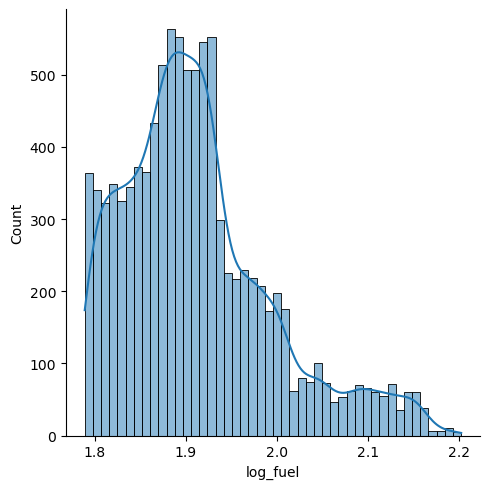

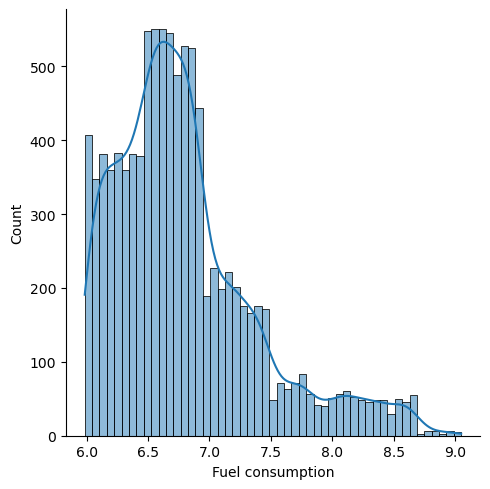

In [92]:
df['log_fuel'] = np.log(df['Fuel consumption'])

print(df['Fuel consumption'].skew(), 'vs', df['log_fuel'].skew())

sns.displot(df, x='log_fuel', kde=True)
sns.displot(df, x='Fuel consumption', kde=True)

While `log transformation` did reduce the skewness, the shape of the data remains unchanged. We will apply `box_cox` transformation to check if it can do a better transformation.

In [93]:
from sklearn.preprocessing import PowerTransformer

cox_transformer = PowerTransformer(method='box-cox')

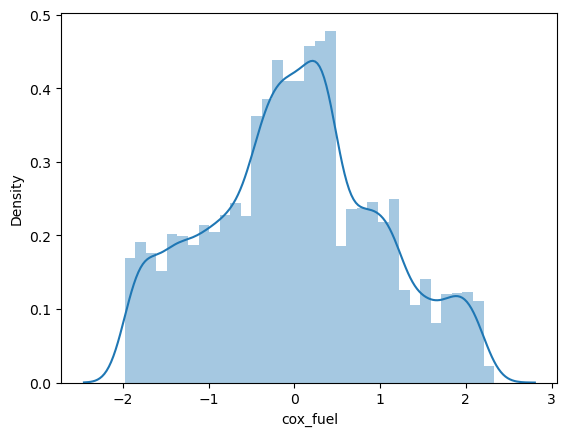

In [94]:
# Fit and transform the data
df['cox_fuel'] = cox_transformer.fit_transform(df[['Fuel consumption']])

sns.distplot(df['cox_fuel'], kde=True)

plt.show()

We will stick with `BoxCox` and drop the `Log` transformed column for `Fuel consumption.

In [95]:
df = df.drop(columns=['Fuel consumption', 'log_fuel'], errors='ignore')
df.head()

,RPM,Failure A,Failure B,Failure C,Failure D,Failure E,Failure Type,Years in service,Temp,usage_low,usage_medium,member_normal,member_premium,model_encoded,color_encoded,country_encoded,cox_fuel
0,1551,0,0,0,0,0,None,1,110.300000,0,1,1,0,1,1,0,-0.179536
1,1408,1,0,0,0,0,A,1,110.400000,0,1,0,1,0,0,0,0.675108
2,1498,0,0,0,0,0,None,1,110.300000,1,0,0,1,0,2,0,0.056121
3,1433,1,0,0,0,0,A,1,110.400000,0,0,0,1,0,0,1,-0.917937
4,1408,0,1,0,0,0,B,1,110.388889,0,0,1,0,0,4,2,-0.152783


## Temperature - Transformation
The distribution is right skewed with a very long tail. This might affect

In [96]:
df['log_temp'] = np.log(df['Temp'])

2.442061237885429 vs 2.3259510211578323


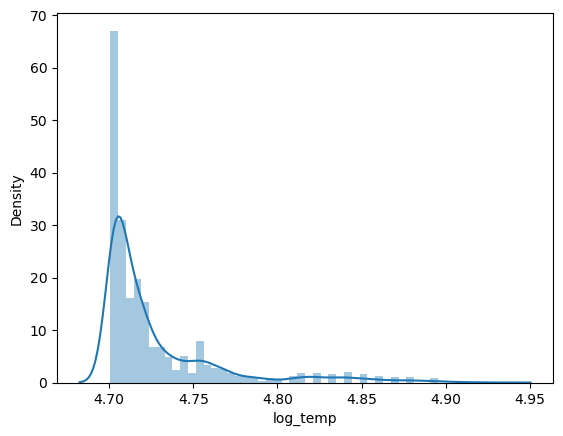

In [97]:
# compare skew changes
print(df['Temp'].skew(), 'vs', df['log_temp'].skew())

sns.distplot(df['log_temp'], kde=True)

plt.show()

Not much changes in the skewness of the data in spite of log transformation, however, we will keep the log-transformed data for our analysis. apply a power transformation to the data to make it more Gaussian-like, henceforth stabilizing the variance and minimize the skewness.

2.442061237885429 vs 2.3259510211578323 vs 0


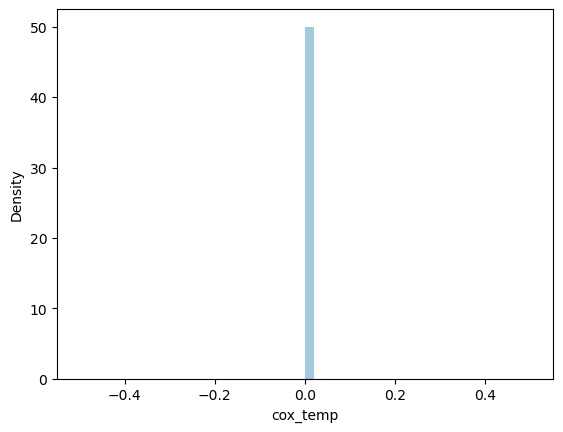

In [98]:
# Fit and transform the data
df['cox_temp'] = cox_transformer.fit_transform(df[['Temp']])

print(df['Temp'].skew(), 'vs', df['log_temp'].skew(), 'vs', df['cox_temp'].skew())

sns.distplot(df['cox_temp'], kde=True)

plt.show()

We will drop `boxcox` as a method as it has over-transformed (likely with a large lambda value, the transformation approaches a square root, which causes the data to become too peaked).

In [99]:
df = df.drop(columns=['cox_temp', 'Temp'], errors='ignore')
df.head()

,RPM,Failure A,Failure B,Failure C,Failure D,Failure E,Failure Type,Years in service,usage_low,usage_medium,member_normal,member_premium,model_encoded,color_encoded,country_encoded,cox_fuel,log_temp
0,1551,0,0,0,0,0,None,1,0,1,1,0,1,1,0,-0.179536,4.703204
1,1408,1,0,0,0,0,A,1,0,1,0,1,0,0,0,0.675108,4.704110
2,1498,0,0,0,0,0,None,1,1,0,0,1,0,2,0,0.056121,4.703204
3,1433,1,0,0,0,0,A,1,0,0,0,1,0,0,1,-0.917937,4.704110
4,1408,0,1,0,0,0,B,1,0,0,1,0,0,4,2,-0.152783,4.704009


## RPM - Transformation
Similar to the temperature distribution, there is a right skew in the `RPM`'s distribution. We will attempt to correct it with log transformation.

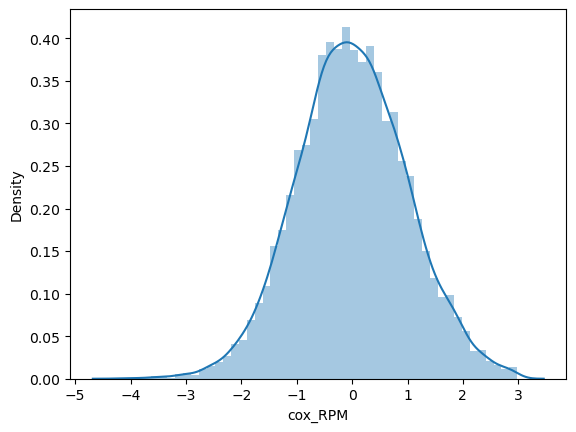

In [100]:
# Fit and transform the data
df['cox_RPM'] = cox_transformer.fit_transform(df[['RPM']])

sns.distplot(df['cox_RPM'], kde=True)

plt.show()

In [101]:
df = df.drop(columns=['RPM'], errors='ignore')
df.head()

,Failure A,Failure B,Failure C,Failure D,Failure E,Failure Type,Years in service,usage_low,usage_medium,member_normal,member_premium,model_encoded,color_encoded,country_encoded,cox_fuel,log_temp,cox_RPM
0,0,0,0,0,0,None,1,0,1,1,0,1,1,0,-0.179536,4.703204,0.309963
1,1,0,0,0,0,A,1,0,1,0,1,0,0,0,0.675108,4.704110,-0.803255
2,0,0,0,0,0,None,1,1,0,0,1,0,2,0,0.056121,4.703204,-0.051609
3,1,0,0,0,0,A,1,0,0,0,1,0,0,1,-0.917937,4.704110,-0.574573
4,0,1,0,0,0,B,1,0,0,1,0,0,4,2,-0.152783,4.704009,-0.803255


# Failure

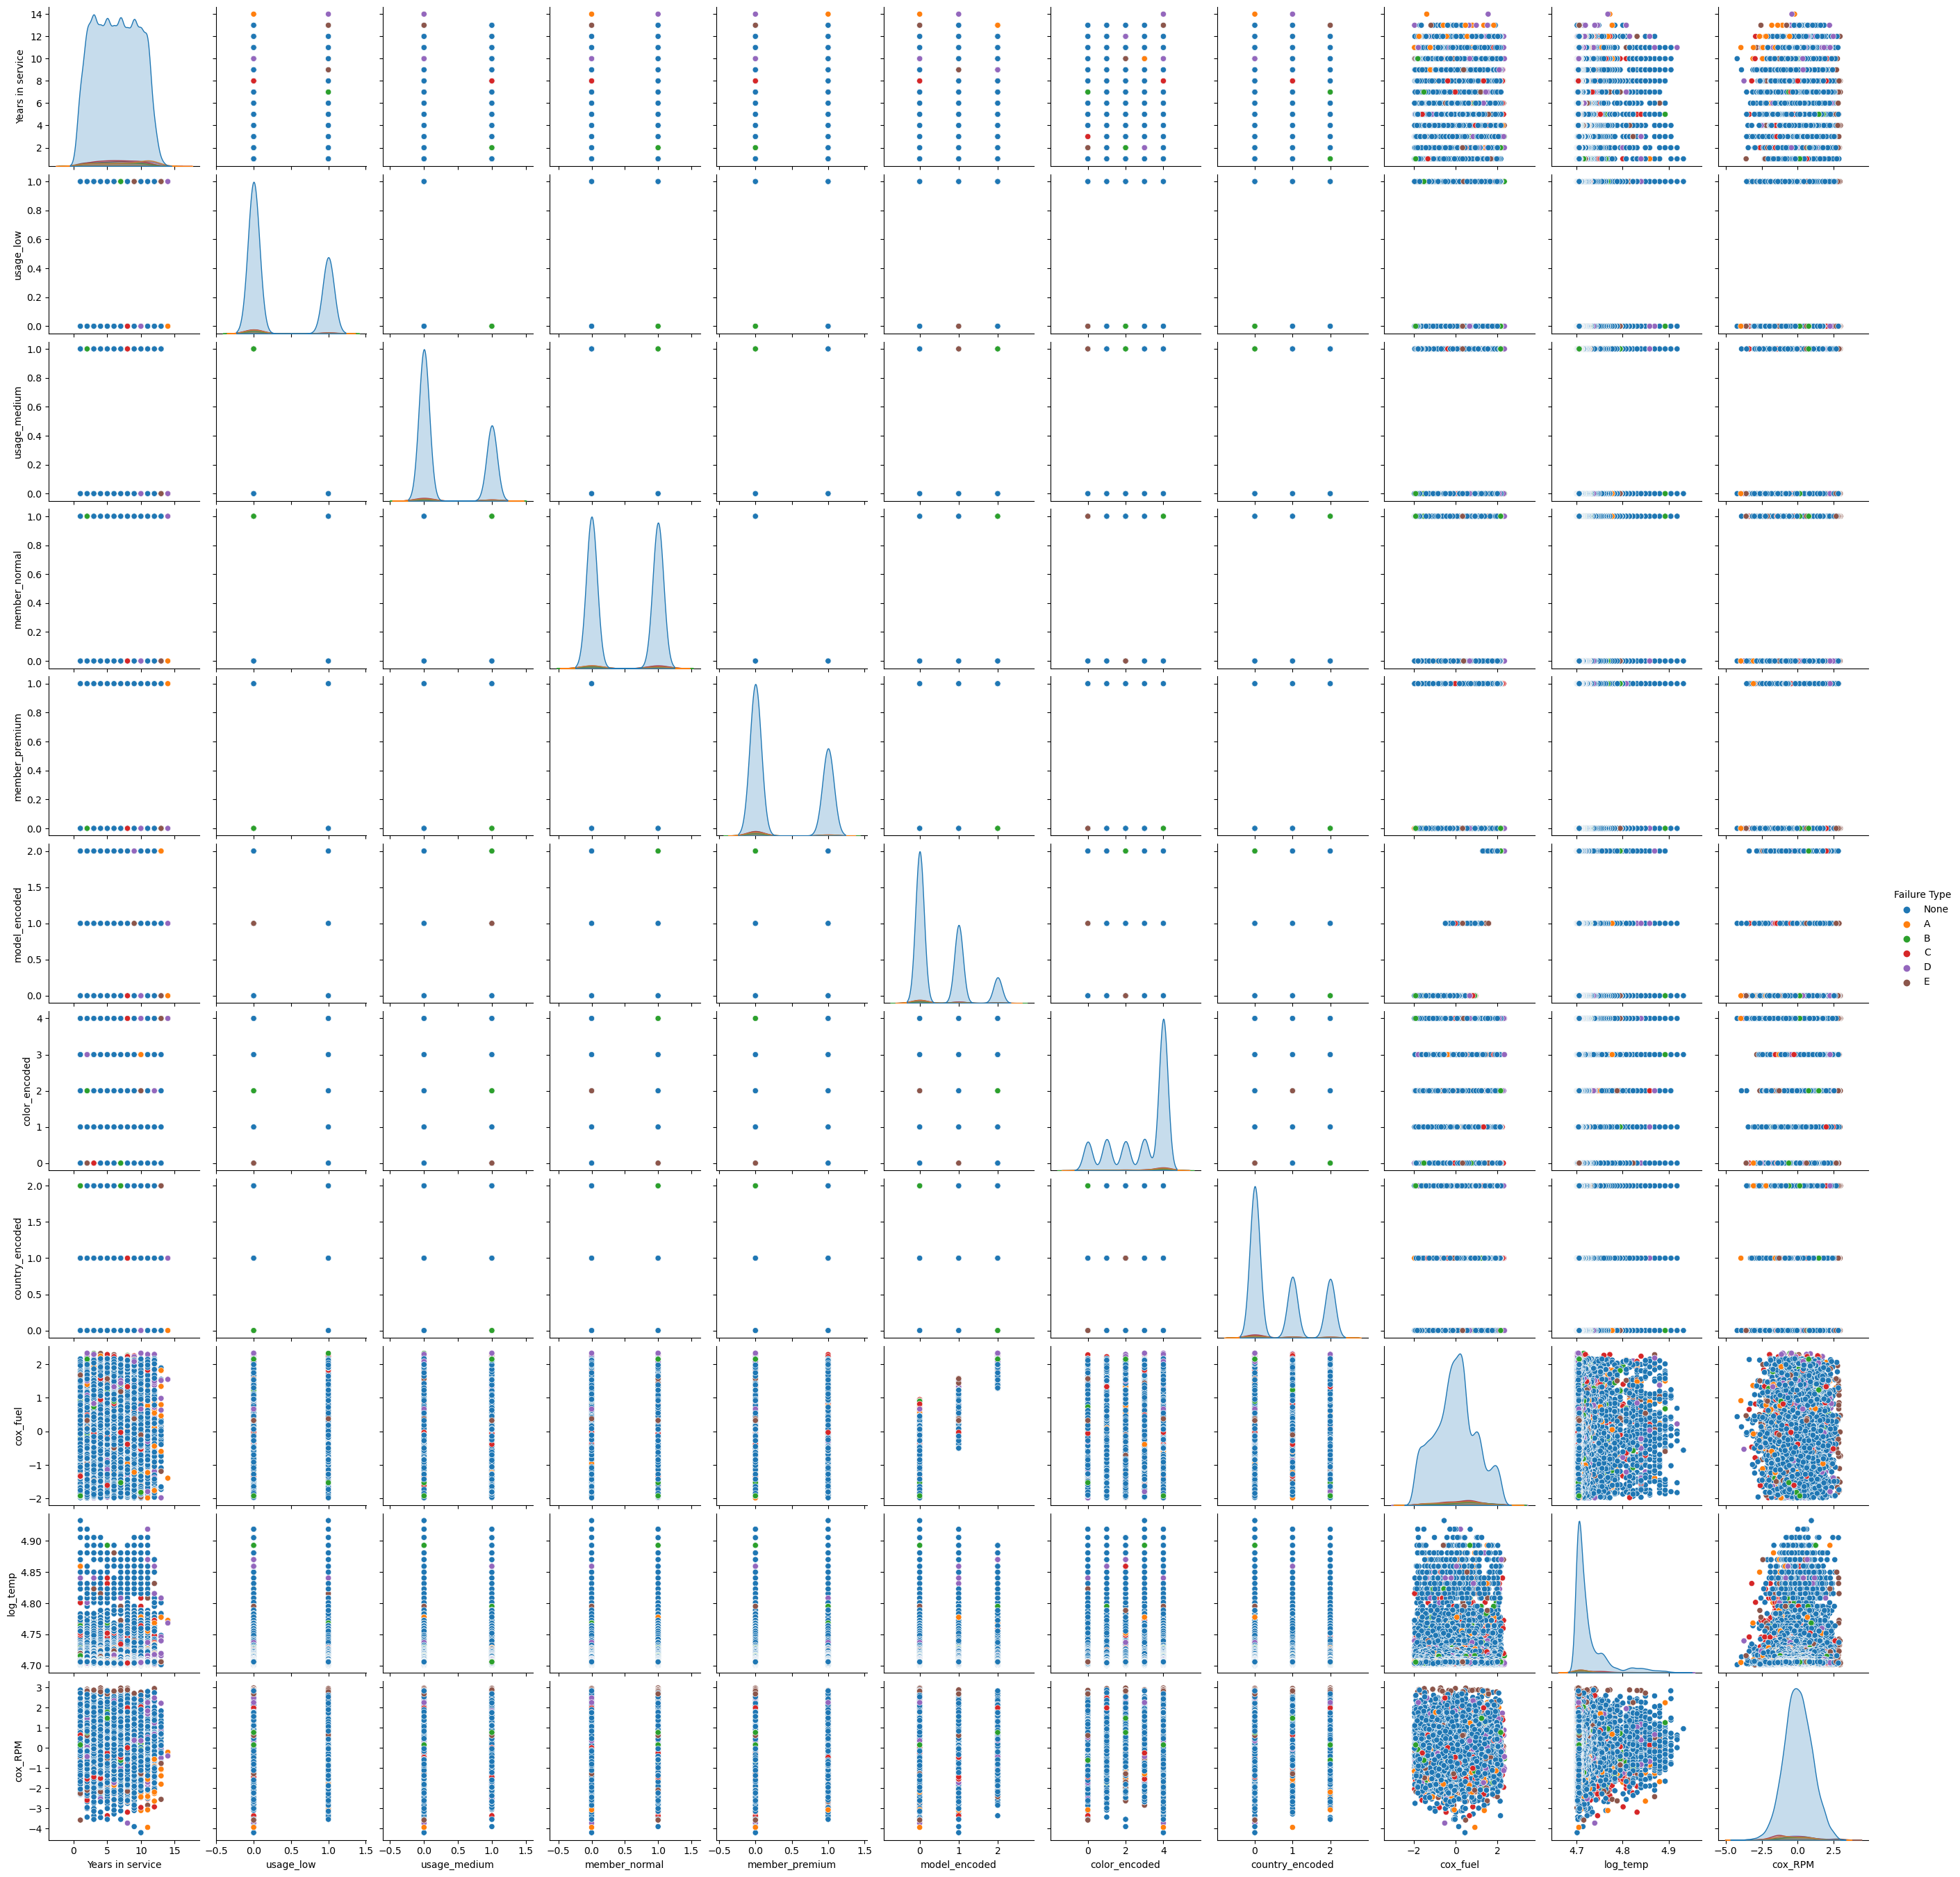

In [102]:
sns.pairplot(df.loc[:, ~df.columns.isin(failure_list)], hue="Failure Type")

In [103]:
# we will save a temp dataframe with all rows that have no failures removed
pure_failures_df = df[df['Failure Type'] != 'None']
pure_failures_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1262 entries, 1 to 9996
Data columns (total 17 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Failure A         1262 non-null   int64  
 1   Failure B         1262 non-null   int64  
 2   Failure C         1262 non-null   int64  
 3   Failure D         1262 non-null   int64  
 4   Failure E         1262 non-null   int64  
 5   Failure Type      1262 non-null   object 
 6   Years in service  1262 non-null   int64  
 7   usage_low         1262 non-null   uint8  
 8   usage_medium      1262 non-null   uint8  
 9   member_normal     1262 non-null   uint8  
 10  member_premium    1262 non-null   uint8  
 11  model_encoded     1262 non-null   int64  
 12  color_encoded     1262 non-null   int64  
 13  country_encoded   1262 non-null   int64  
 14  cox_fuel          1262 non-null   float64
 15  log_temp          1262 non-null   float64
 16  cox_RPM           1262 non-null   float64


In [104]:
# we will also save another one where only one target variable, 'Failure', 
# on whether a car experienced failure regardless of types

single_failure_df = df.drop(columns=[*failure_list])
single_failure_df['Failure Type'] = single_failure_df['Failure Type'].replace(['A','B','C','D','E'], 1)
single_failure_df['Failure Type'] = single_failure_df['Failure Type'].replace('None', 0)

single_failure_df.rename(columns={'Failure Type': 'Failed'}, inplace=True)
single_failure_df

,Failed,Years in service,usage_low,usage_medium,member_normal,member_premium,model_encoded,color_encoded,country_encoded,cox_fuel,log_temp,cox_RPM
0,0,1,0,1,1,0,1,1,0,-0.179536,4.703204,0.309963
1,1,1,0,1,0,1,0,0,0,0.675108,4.704110,-0.803255
2,0,1,1,0,0,1,0,2,0,0.056121,4.703204,-0.051609
3,1,1,0,0,0,1,0,0,1,-0.917937,4.704110,-0.574573
4,1,1,0,0,1,0,0,4,2,-0.152783,4.704009,-0.803255
...,...,...,...,...,...,...,...,...,...,...,...,...
9995,1,2,0,1,1,0,1,0,0,0.325358,4.705920,0.623568
9996,1,2,0,1,1,0,2,2,0,2.150201,4.705920,0.772543
9997,0,2,1,0,0,1,1,4,0,-0.499636,4.705920,0.838161
9998,0,2,0,0,0,1,2,4,2,1.991151,4.706021,-0.803255


In [105]:
# df = df.drop(columns=['Failure Type'], errors='ignore')
df.head()

,Failure A,Failure B,Failure C,Failure D,Failure E,Failure Type,Years in service,usage_low,usage_medium,member_normal,member_premium,model_encoded,color_encoded,country_encoded,cox_fuel,log_temp,cox_RPM
0,0,0,0,0,0,None,1,0,1,1,0,1,1,0,-0.179536,4.703204,0.309963
1,1,0,0,0,0,A,1,0,1,0,1,0,0,0,0.675108,4.704110,-0.803255
2,0,0,0,0,0,None,1,1,0,0,1,0,2,0,0.056121,4.703204,-0.051609
3,1,0,0,0,0,A,1,0,0,0,1,0,0,1,-0.917937,4.704110,-0.574573
4,0,1,0,0,0,B,1,0,0,1,0,0,4,2,-0.152783,4.704009,-0.803255


In [106]:
pure_failures_df
# convert all columns to one sole failure column

,Failure A,Failure B,Failure C,Failure D,Failure E,Failure Type,Years in service,usage_low,usage_medium,member_normal,member_premium,model_encoded,color_encoded,country_encoded,cox_fuel,log_temp,cox_RPM
1,1,0,0,0,0,A,1,0,1,0,1,0,0,0,0.675108,4.704110,-0.803255
3,1,0,0,0,0,A,1,0,0,0,1,0,0,1,-0.917937,4.704110,-0.574573
4,0,1,0,0,0,B,1,0,0,1,0,0,4,2,-0.152783,4.704009,-0.803255
18,0,0,1,0,0,C,3,0,0,1,0,2,0,0,2.279335,4.705920,-1.937330
24,0,1,0,0,0,B,5,1,0,0,1,1,4,2,0.152517,4.706021,0.372551
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9974,0,0,0,0,1,E,10,0,0,0,0,0,2,1,-0.104415,4.705016,-1.282021
9980,0,0,0,1,0,D,10,0,0,0,0,0,4,0,0.665745,4.705016,0.360168
9990,0,1,0,0,0,B,1,0,0,1,0,0,4,2,-1.919848,4.705518,0.152697
9995,0,0,0,0,1,E,2,0,1,1,0,1,0,0,0.325358,4.705920,0.623568


In [107]:
from numpy.random import default_rng

# we will save a temp dataframe with all rows that have no failures removed
pure_nonfailures_df = df[df['Failure Type'] == 'None']

# get the mean distribution of failures
num_rows = int(pure_failures_df.loc[:, pure_failures_df.columns!='Failure Type'].filter(like='Failure').sum().mean())
rows_to_be_removed = len(pure_nonfailures_df) - num_rows

# randomly remove rows so the df is left with `mean` number of rows
arr_indices_top_drop = default_rng().choice(pure_nonfailures_df.index, size=rows_to_be_removed, replace=False)
pure_nonfailures_df = pure_nonfailures_df.drop(index=arr_indices_top_drop)

# concat pure_nonfail and pure_fail
equal_dist_df = pd.concat([pure_failures_df, pure_nonfailures_df])
equal_dist_df = equal_dist_df.drop(columns=['Failure A','Failure B','Failure C','Failure D','Failure E'], errors='ignore')


# label encode 'Failure Type'
failure_le = LabelEncoder()

# Fit and transform the 'color' column of the DataFrame
equal_dist_df['Failure Type'] = failure_le.fit_transform(equal_dist_df['Failure Type'])

# Get the mapping of original labels to encoded integers
failure_mapping = dict(zip(failure_le.classes_, failure_le.transform(failure_le.classes_)))
print(failure_mapping)
equal_dist_df

{'A': 0, 'B': 1, 'C': 2, 'D': 3, 'E': 4, 'None': 5}


,Failure Type,Years in service,usage_low,usage_medium,member_normal,member_premium,model_encoded,color_encoded,country_encoded,cox_fuel,log_temp,cox_RPM
1,0,1,0,1,0,1,0,0,0,0.675108,4.704110,-0.803255
3,0,1,0,0,0,1,0,0,1,-0.917937,4.704110,-0.574573
4,1,1,0,0,1,0,0,4,2,-0.152783,4.704009,-0.803255
18,2,3,0,0,1,0,2,0,0,2.279335,4.705920,-1.937330
24,1,5,1,0,0,1,1,4,2,0.152517,4.706021,0.372551
...,...,...,...,...,...,...,...,...,...,...,...,...
9722,5,7,1,0,1,0,2,1,1,1.897945,4.705920,1.813115
9813,5,9,0,0,1,0,0,3,0,-0.958285,4.704110,-1.008838
9823,5,10,0,1,0,0,1,4,0,0.203193,4.704110,-0.125942
9855,5,4,0,1,0,1,0,2,2,-0.861136,4.705016,0.077115


<AxesSubplot: xlabel='Failure Type', ylabel='count'>

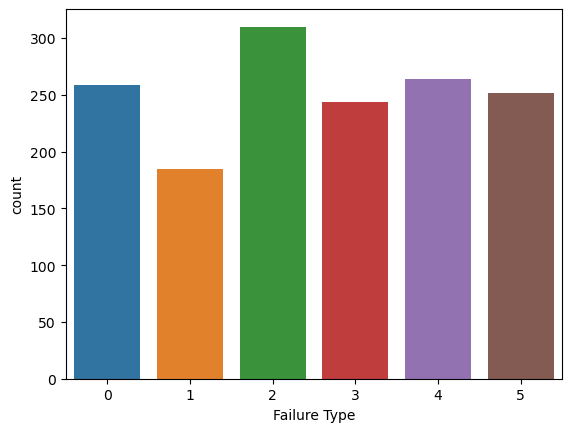

In [108]:
# map distribution of failure colummns
sns.countplot(data=equal_dist_df, x='Failure Type')

In [109]:
pure_failures_df

,Failure A,Failure B,Failure C,Failure D,Failure E,Failure Type,Years in service,usage_low,usage_medium,member_normal,member_premium,model_encoded,color_encoded,country_encoded,cox_fuel,log_temp,cox_RPM
1,1,0,0,0,0,A,1,0,1,0,1,0,0,0,0.675108,4.704110,-0.803255
3,1,0,0,0,0,A,1,0,0,0,1,0,0,1,-0.917937,4.704110,-0.574573
4,0,1,0,0,0,B,1,0,0,1,0,0,4,2,-0.152783,4.704009,-0.803255
18,0,0,1,0,0,C,3,0,0,1,0,2,0,0,2.279335,4.705920,-1.937330
24,0,1,0,0,0,B,5,1,0,0,1,1,4,2,0.152517,4.706021,0.372551
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9974,0,0,0,0,1,E,10,0,0,0,0,0,2,1,-0.104415,4.705016,-1.282021
9980,0,0,0,1,0,D,10,0,0,0,0,0,4,0,0.665745,4.705016,0.360168
9990,0,1,0,0,0,B,1,0,0,1,0,0,4,2,-1.919848,4.705518,0.152697
9995,0,0,0,0,1,E,2,0,1,1,0,1,0,0,0.325358,4.705920,0.623568


## Detecting Multi-Collinearity

When there is a high correlation between the independent variables in a regression analysis, it is referred to as multi-collinearity (MC). This can affect the interpretation of the results and make it difficult to determine the significance of individual independent variables. 

One way to identify MC is to use a correlation plot to examine the relationship between pairs of independent variables. Another method is to use the variance inflation factor (VIF) to measure the correlation of one independent variable with a group of other variables. This is done to understand the individual impact of each independent variable on the dependent variable.

### Correlation Plot

<AxesSubplot: >

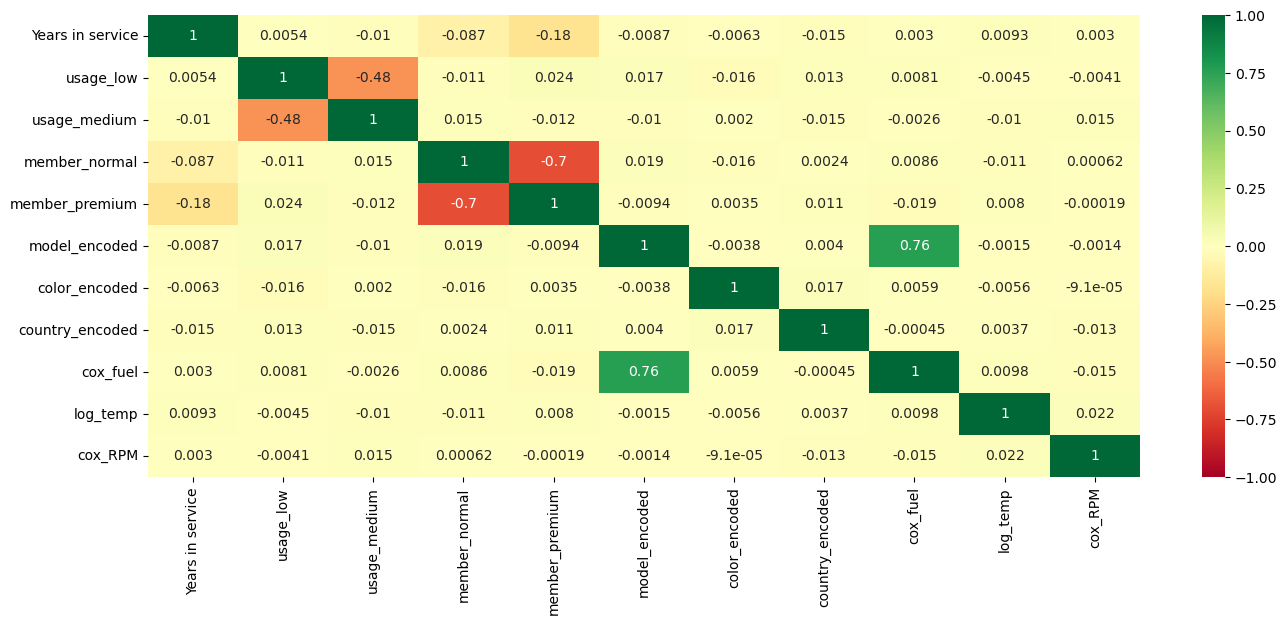

In [110]:
plt.figure(figsize=(16, 6))

feat_df = df.loc[:, ~df.columns.isin(failure_list)]

corr = feat_df.corr()

sns.heatmap(corr, fmt='.2g',cmap= 'RdYlGn', vmin=-1, vmax=1, annot=True)

From the above matrix, other than the diagonal, `model_encoded` (alias for Car Model) and `cox_fuel` (alias for Car's Fuel Consumption) are highly correlated. In this case, it would not matter which one to drop since either variables display low correlation with other independent variables, but I would be dropping `cox_fuel` to reduce variability.

In [111]:
df = df.drop(columns=['cox_fuel'], errors='ignore')

## Variance Inflation Factor (VIF) Analysis

In [112]:
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

vif_df = df.loc[:, ~df.columns.isin(failure_list)]
vif_df = vif_df.loc[:, vif_df.columns!='Failure Type']
vif_df = vif_df.astype(float)

vif_info = pd.DataFrame()

vif_info['VIF'] = [variance_inflation_factor(vif_df.values, i)
                          for i in range(len(vif_df.columns))]
vif_info['Column'] = vif_df.columns
vif_info.sort_values('VIF', ascending=False)

,VIF,Column
8,21.564271,log_temp
0,5.656595,Years in service
6,5.099408,color_encoded
3,4.213859,member_normal
4,3.366567,member_premium
2,1.945999,usage_medium
1,1.891471,usage_low
7,1.648811,country_encoded
5,1.556553,model_encoded
9,1.000383,cox_RPM


We can see that `log_temp` displays a high VIF. When VIF is > 10, there is a high correlation 

In [113]:
vif_df = df.loc[:, ~df.columns.isin(failure_list)]
vif_df = vif_df.loc[:,  ~vif_df.columns.isin(['log_temp','Failure Type'])]
vif_df = vif_df.astype(float)

vif_info = pd.DataFrame()

vif_info['VIF'] = [variance_inflation_factor(vif_df.values, i)
                          for i in range(len(vif_df.columns))]
vif_info['Column'] = vif_df.columns
vif_info.sort_values('VIF', ascending=False)

,VIF,Column
6,4.059854,color_encoded
0,3.380492,Years in service
3,2.624320,member_normal
4,2.128208,member_premium
2,1.820855,usage_medium
1,1.784826,usage_low
7,1.604830,country_encoded
5,1.518200,model_encoded
8,1.000378,cox_RPM


We see that removing the `log_temp` feature reduces VIF across the board, hence we will drop it from the evaluation.

In [114]:
df = df.drop(columns=['log_temp'], errors='ignore')

In [115]:
df.head()

,Failure A,Failure B,Failure C,Failure D,Failure E,Failure Type,Years in service,usage_low,usage_medium,member_normal,member_premium,model_encoded,color_encoded,country_encoded,cox_RPM
0,0,0,0,0,0,None,1,0,1,1,0,1,1,0,0.309963
1,1,0,0,0,0,A,1,0,1,0,1,0,0,0,-0.803255
2,0,0,0,0,0,None,1,1,0,0,1,0,2,0,-0.051609
3,1,0,0,0,0,A,1,0,0,0,1,0,0,1,-0.574573
4,0,1,0,0,0,B,1,0,0,1,0,0,4,2,-0.803255


<AxesSubplot: >

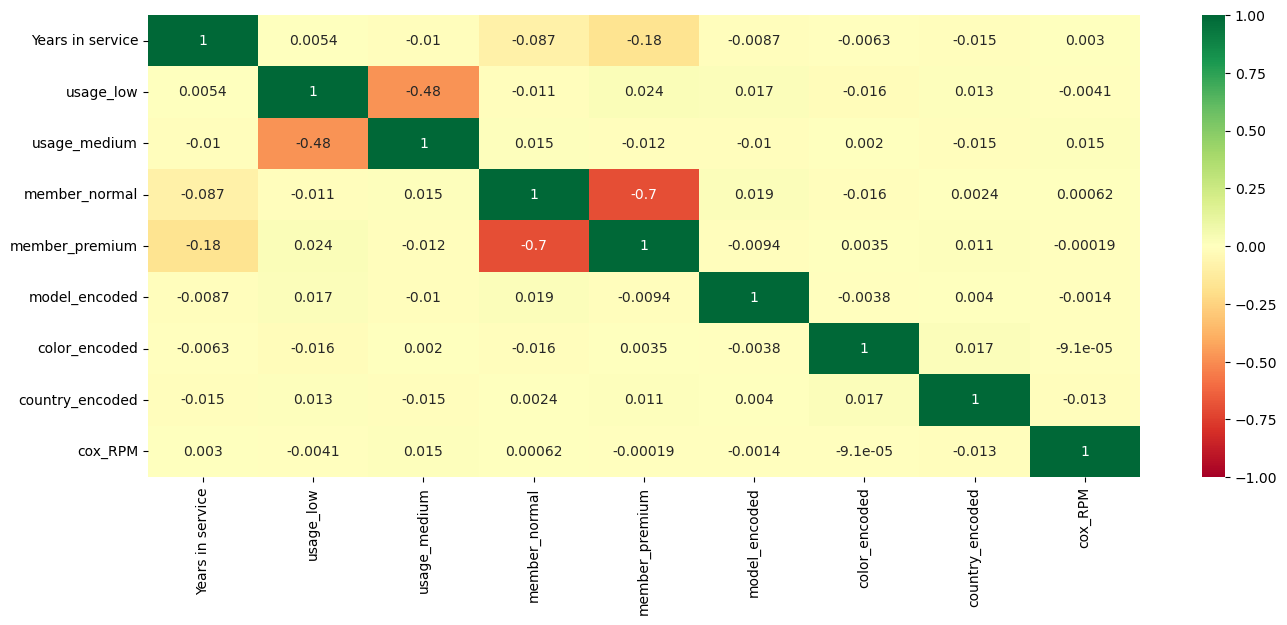

In [116]:
plt.figure(figsize=(16, 6))
feat_df = df.loc[:, ~df.columns.isin(failure_list)]

corr = feat_df.corr()
sns.heatmap(corr, fmt='.2g',cmap= 'RdYlGn', vmin=-1, vmax=1, annot=True)

# 3. Build Models Pipeline
We will first split the data into training and test data using `KFold`.

### Main

In [143]:
# train test split using KFold
from sklearn.model_selection import StratifiedKFold
import pandas as pd

# Define the number of splits (in this case, 6) and random_state for reproducibility
skf = StratifiedKFold(n_splits=6, shuffle=True, random_state=123)

In [118]:
# define the targets and features
targets = failure_list #[Failure A, Failure B...]
features = [feature for feature in df.columns.to_list() if feature not in failure_list and feature!= 'Failure Type']

X, y = df[features], df[targets]

In [119]:
y

,Failure A,Failure B,Failure C,Failure D,Failure E
0,0,0,0,0,0
1,1,0,0,0,0
2,0,0,0,0,0
3,1,0,0,0,0
4,0,1,0,0,0
...,...,...,...,...,...
9995,0,0,0,0,1
9996,0,1,0,0,0
9997,0,0,0,0,0
9998,0,0,0,0,0


### Pure Failures (removal of rows that have no failures)

In [120]:
targets = failure_list #[Failure A, Failure B...]
features = [feature for feature in df.columns.to_list() if feature not in failure_list and feature!= 'Failure Type']

pure_failures_X, pure_failures_y = pure_failures_df[features], pure_failures_df[targets]

### Single Failure (merge of all failures into a categorical column)

In [121]:
targets = 'Failed' #[Failure A, Failure B...]
features = [feature for feature in single_failure_df.columns.to_list() if feature != 'Failed']

single_failure_X, single_failure_y = single_failure_df[features], single_failure_df[targets]

### Equal Distributed

In [122]:
# equal_dist_df
targets = 'Failure Type'
features = [feature for feature in equal_dist_df.columns.to_list() if feature not in failure_list and feature!= 'Failure Type']

equal_failure_X, equal_failure_y = equal_dist_df[features], equal_dist_df[targets]

In [123]:
equal_failure_X

,Years in service,usage_low,usage_medium,member_normal,member_premium,model_encoded,color_encoded,country_encoded,cox_fuel,log_temp,cox_RPM
1,1,0,1,0,1,0,0,0,0.675108,4.704110,-0.803255
3,1,0,0,0,1,0,0,1,-0.917937,4.704110,-0.574573
4,1,0,0,1,0,0,4,2,-0.152783,4.704009,-0.803255
18,3,0,0,1,0,2,0,0,2.279335,4.705920,-1.937330
24,5,1,0,0,1,1,4,2,0.152517,4.706021,0.372551
...,...,...,...,...,...,...,...,...,...,...,...
9722,7,1,0,1,0,2,1,1,1.897945,4.705920,1.813115
9813,9,0,0,1,0,0,3,0,-0.958285,4.704110,-1.008838
9823,10,0,1,0,0,1,4,0,0.203193,4.704110,-0.125942
9855,4,0,1,0,1,0,2,2,-0.861136,4.705016,0.077115


In [173]:
from sklearn.model_selection import GridSearchCV

### Logistic Regression

In [177]:
from sklearn.linear_model import LogisticRegression

X = equal_failure_X
y = equal_failure_y

logistic_params = {
    'penalty': ['l2', 'l2', 'elasticnet'],
    'C': [0.1, 1, 10],
    'solver': ['newton-cg', 'lbfgs', 'liblinear'],
    'multi_class': ['multinomial','ovr'],
    'max_iter': [800]
    }

for index, (train_index, test_index) in enumerate(skf.split(X, y)):

        print(f"Running fold {index} of 6 folds")
        # we only need training data for now
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        for index in range(len(models)):
            print('Running Logistic Regression')
 
            grid_search = GridSearchCV(LogisticRegression(), 
                                    logistic_params, 
                                    cv=6, 
                                    scoring=scoring_metrics,
                                    refit='f1_micro', 
                                    n_jobs=-1,
                                    verbose=1
                                      )
            grid_search.fit(X_train, y_train)

            # extract the best estimator, params
            best_estimator = grid_search.best_estimator_
            best_param = grid_search.best_params_
            
            print(f"Accuracy for the fold {index} on the test set: {accuracy_score(y_test, best_estimator.predict(X_test))}")

Running fold 0 of 6 folds
Running Logistic Regression
Fitting 6 folds for each of 54 candidates, totalling 324 fits


/Users/wongshennan/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/wongshennan/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_mode

Accuracy for the fold 0 on the test set: 0.31620553359683795
Running Logistic Regression
Fitting 6 folds for each of 54 candidates, totalling 324 fits


/Users/wongshennan/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/wongshennan/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_mode

Accuracy for the fold 1 on the test set: 0.31620553359683795
Running Logistic Regression
Fitting 6 folds for each of 54 candidates, totalling 324 fits


/Users/wongshennan/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/wongshennan/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_mode

Accuracy for the fold 2 on the test set: 0.31620553359683795
Running Logistic Regression
Fitting 6 folds for each of 54 candidates, totalling 324 fits


/Users/wongshennan/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/wongshennan/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_mode

Accuracy for the fold 3 on the test set: 0.31620553359683795
Running Logistic Regression
Fitting 6 folds for each of 54 candidates, totalling 324 fits


/Users/wongshennan/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/wongshennan/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_mode

Accuracy for the fold 4 on the test set: 0.31620553359683795
Running Logistic Regression
Fitting 6 folds for each of 54 candidates, totalling 324 fits


/Users/wongshennan/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/wongshennan/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_mode

Accuracy for the fold 5 on the test set: 0.31620553359683795
Running Logistic Regression
Fitting 6 folds for each of 54 candidates, totalling 324 fits


/Users/wongshennan/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/wongshennan/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_mode

Accuracy for the fold 6 on the test set: 0.31620553359683795
Running Logistic Regression
Fitting 6 folds for each of 54 candidates, totalling 324 fits


/Users/wongshennan/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/wongshennan/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_mode

Accuracy for the fold 7 on the test set: 0.31620553359683795
Running fold 1 of 6 folds
Running Logistic Regression
Fitting 6 folds for each of 54 candidates, totalling 324 fits


/Users/wongshennan/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/wongshennan/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_mode

Accuracy for the fold 0 on the test set: 0.2885375494071146
Running Logistic Regression
Fitting 6 folds for each of 54 candidates, totalling 324 fits


/Users/wongshennan/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/wongshennan/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_mode

Accuracy for the fold 1 on the test set: 0.2885375494071146
Running Logistic Regression
Fitting 6 folds for each of 54 candidates, totalling 324 fits


/Users/wongshennan/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/wongshennan/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_mode

Accuracy for the fold 2 on the test set: 0.2885375494071146
Running Logistic Regression
Fitting 6 folds for each of 54 candidates, totalling 324 fits


/Users/wongshennan/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/wongshennan/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_mode

Accuracy for the fold 3 on the test set: 0.2885375494071146
Running Logistic Regression
Fitting 6 folds for each of 54 candidates, totalling 324 fits


/Users/wongshennan/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/wongshennan/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_mode

Accuracy for the fold 4 on the test set: 0.2885375494071146
Running Logistic Regression
Fitting 6 folds for each of 54 candidates, totalling 324 fits


/Users/wongshennan/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/wongshennan/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_mode

Accuracy for the fold 5 on the test set: 0.2885375494071146
Running Logistic Regression
Fitting 6 folds for each of 54 candidates, totalling 324 fits


/Users/wongshennan/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/wongshennan/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_mode

Accuracy for the fold 6 on the test set: 0.2885375494071146
Running Logistic Regression
Fitting 6 folds for each of 54 candidates, totalling 324 fits


/Users/wongshennan/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/wongshennan/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_mode

Accuracy for the fold 7 on the test set: 0.2885375494071146
Running fold 2 of 6 folds
Running Logistic Regression
Fitting 6 folds for each of 54 candidates, totalling 324 fits


/Users/wongshennan/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/wongshennan/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_mode

Accuracy for the fold 0 on the test set: 0.2619047619047619
Running Logistic Regression
Fitting 6 folds for each of 54 candidates, totalling 324 fits


/Users/wongshennan/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/wongshennan/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_mode

Accuracy for the fold 1 on the test set: 0.2619047619047619
Running Logistic Regression
Fitting 6 folds for each of 54 candidates, totalling 324 fits


/Users/wongshennan/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/wongshennan/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_mode

Accuracy for the fold 2 on the test set: 0.2619047619047619
Running Logistic Regression
Fitting 6 folds for each of 54 candidates, totalling 324 fits


/Users/wongshennan/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/wongshennan/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_mode

Accuracy for the fold 3 on the test set: 0.2619047619047619
Running Logistic Regression
Fitting 6 folds for each of 54 candidates, totalling 324 fits


/Users/wongshennan/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/wongshennan/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_mode

Accuracy for the fold 4 on the test set: 0.2619047619047619
Running Logistic Regression
Fitting 6 folds for each of 54 candidates, totalling 324 fits


/Users/wongshennan/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/wongshennan/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_mode

Accuracy for the fold 5 on the test set: 0.2619047619047619
Running Logistic Regression
Fitting 6 folds for each of 54 candidates, totalling 324 fits


/Users/wongshennan/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/wongshennan/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_mode

Accuracy for the fold 6 on the test set: 0.2619047619047619
Running Logistic Regression
Fitting 6 folds for each of 54 candidates, totalling 324 fits


/Users/wongshennan/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/wongshennan/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_mode

Accuracy for the fold 7 on the test set: 0.2619047619047619
Running fold 3 of 6 folds
Running Logistic Regression
Fitting 6 folds for each of 54 candidates, totalling 324 fits


/Users/wongshennan/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/wongshennan/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_mode

Accuracy for the fold 0 on the test set: 0.25
Running Logistic Regression
Fitting 6 folds for each of 54 candidates, totalling 324 fits


/Users/wongshennan/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/wongshennan/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_mode

Accuracy for the fold 1 on the test set: 0.25
Running Logistic Regression
Fitting 6 folds for each of 54 candidates, totalling 324 fits


/Users/wongshennan/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/wongshennan/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_mode

Accuracy for the fold 2 on the test set: 0.25
Running Logistic Regression
Fitting 6 folds for each of 54 candidates, totalling 324 fits


/Users/wongshennan/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/wongshennan/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_mode

Accuracy for the fold 3 on the test set: 0.25
Running Logistic Regression
Fitting 6 folds for each of 54 candidates, totalling 324 fits


/Users/wongshennan/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/wongshennan/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_mode

Accuracy for the fold 4 on the test set: 0.25
Running Logistic Regression
Fitting 6 folds for each of 54 candidates, totalling 324 fits


/Users/wongshennan/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/wongshennan/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_mode

Accuracy for the fold 5 on the test set: 0.25
Running Logistic Regression
Fitting 6 folds for each of 54 candidates, totalling 324 fits


/Users/wongshennan/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/wongshennan/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_mode

Accuracy for the fold 6 on the test set: 0.25
Running Logistic Regression
Fitting 6 folds for each of 54 candidates, totalling 324 fits


/Users/wongshennan/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/wongshennan/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_mode

Accuracy for the fold 7 on the test set: 0.25
Running fold 4 of 6 folds
Running Logistic Regression
Fitting 6 folds for each of 54 candidates, totalling 324 fits


/Users/wongshennan/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/wongshennan/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_mode

Accuracy for the fold 0 on the test set: 0.32142857142857145
Running Logistic Regression
Fitting 6 folds for each of 54 candidates, totalling 324 fits


/Users/wongshennan/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/wongshennan/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_mode

Accuracy for the fold 1 on the test set: 0.32142857142857145
Running Logistic Regression
Fitting 6 folds for each of 54 candidates, totalling 324 fits


/Users/wongshennan/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/wongshennan/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_mode

Accuracy for the fold 2 on the test set: 0.32142857142857145
Running Logistic Regression
Fitting 6 folds for each of 54 candidates, totalling 324 fits


/Users/wongshennan/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/wongshennan/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_mode

Accuracy for the fold 3 on the test set: 0.32142857142857145
Running Logistic Regression
Fitting 6 folds for each of 54 candidates, totalling 324 fits


/Users/wongshennan/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/wongshennan/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_mode

Accuracy for the fold 4 on the test set: 0.32142857142857145
Running Logistic Regression
Fitting 6 folds for each of 54 candidates, totalling 324 fits


/Users/wongshennan/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/wongshennan/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_mode

Accuracy for the fold 5 on the test set: 0.32142857142857145
Running Logistic Regression
Fitting 6 folds for each of 54 candidates, totalling 324 fits


/Users/wongshennan/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/wongshennan/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_mode

Accuracy for the fold 6 on the test set: 0.32142857142857145
Running Logistic Regression
Fitting 6 folds for each of 54 candidates, totalling 324 fits


/Users/wongshennan/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/wongshennan/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_mode

Accuracy for the fold 7 on the test set: 0.32142857142857145
Running fold 5 of 6 folds
Running Logistic Regression
Fitting 6 folds for each of 54 candidates, totalling 324 fits


/Users/wongshennan/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/wongshennan/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_mode

Accuracy for the fold 0 on the test set: 0.27380952380952384
Running Logistic Regression
Fitting 6 folds for each of 54 candidates, totalling 324 fits


/Users/wongshennan/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/wongshennan/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_mode

Accuracy for the fold 1 on the test set: 0.27380952380952384
Running Logistic Regression
Fitting 6 folds for each of 54 candidates, totalling 324 fits


/Users/wongshennan/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/wongshennan/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_mode

Accuracy for the fold 2 on the test set: 0.27380952380952384
Running Logistic Regression
Fitting 6 folds for each of 54 candidates, totalling 324 fits


/Users/wongshennan/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/wongshennan/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_mode

Accuracy for the fold 3 on the test set: 0.27380952380952384
Running Logistic Regression
Fitting 6 folds for each of 54 candidates, totalling 324 fits


/Users/wongshennan/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/wongshennan/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_mode

Accuracy for the fold 4 on the test set: 0.27380952380952384
Running Logistic Regression
Fitting 6 folds for each of 54 candidates, totalling 324 fits


/Users/wongshennan/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/wongshennan/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_mode

Accuracy for the fold 5 on the test set: 0.27380952380952384
Running Logistic Regression
Fitting 6 folds for each of 54 candidates, totalling 324 fits


/Users/wongshennan/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/wongshennan/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_mode

Accuracy for the fold 6 on the test set: 0.27380952380952384
Running Logistic Regression
Fitting 6 folds for each of 54 candidates, totalling 324 fits


/Users/wongshennan/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/wongshennan/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_mode

Accuracy for the fold 7 on the test set: 0.27380952380952384


/Users/wongshennan/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


### Decision Tree

In [ ]:
from sklearn.tree import DecisionTreeClassifier

decision_params = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [5, 10, 20, 30, 40, 50],
    'min_samples_split': [1, 2, 3, 4, 5],
    }

### Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier

forest_params = {
    'n_estimators': [50, 100, 200, 300],
    'criterion': ['gini', 'entropy'],
    'max_depth': [5, 10, 20],
    'min_sample_leafs': [1,2,3,4,5],
    'max_features': [0.5, 0.7, 'sqrt', 'log2']
    }


### Support Vector Classifier

In [ ]:
from sklearn.svm import SVC


### K-Nearest Neighbors

In [ ]:
from sklearn.neighbors import KNeighborsClassifier


In [ ]:
from sklearn.neural_network import MLPClassifier


In [ ]:
from sklearn.naive_bayes import MultinomialNB


In [ ]:
from sklearn.ensemble import GradientBoostingClassifier


In [ ]:
import xgboost as xgb


In [ ]:
import lightgbm as lgb


In [ ]:
from catboost import CatBoostClassifier

# define the hyperparameter grid for the models




gb_params = {'learning_rate': [0.1, 0.05, 0.01],
                 'max_depth': [3, 5, 7],
                 'n_estimators': [100, 300, 500]}


nb_params = {
    'alpha': [0.1, 0.5, 1.0], 
    'fit_prior': [True, False]
    }

mlp_params = {
    'hidden_layer_sizes': [(50, 50, 50), (100, 100, 100), (100, 100)],
    'activation': ['relu', 'tanh', 'logistic'],
    'solver': ['adam','sgd'],
    'learning_rate': ['constant','adaptive','invscaling'],
    'learning_rate_init': [0.001, 0.01, 0.1, 1],
    'alpha':[0.0001, .001],
    'batch_size': [32, 64, 128],
    'max_iter': [400]
    }

svc_params = {'C': [0.1, 1, 10],
              'kernel': ['linear'],
              'degree': [2, 3, 4],
              'gamma': [0.1, 1, 'scale'],
              'coef0': [0, 1, 2],
              'probability':[True],
              'shrinking':[True,False]}

knn_params = {
    'n_neighbors': [3, 5, 7, 9],
    'weights': ['uniform', 'distance'],
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']
    }

xgb_params = {
    'learning_rate': [0.1, 0.05, 0.01],
    'max_depth': [3, 5, 7],
    'n_estimators': [100, 300, 500]
}

lgb_params = {
    'learning_rate': [0.1, 0.05, 0.01],
    'max_depth': [-1, 3, 5, 7],
    'n_estimators': [100, 300, 500]
}

cat_params = {
    'learning_rate': [0.1, 0.05, 0.01],
    'depth': [3, 5, 7],
    'iterations': [100, 300, 500]
}

In [170]:
from sklearn.metrics import accuracy_score

scoring_metrics = ['recall_macro','roc_auc_ovr','f1_micro']

def gridSearchForBestModel(skf, X, y, models):
    
    best_models = []
    best_params = []
    classifiers = []
    
    for index, (train_index, test_index) in enumerate(skf.split(X, y)):

        print(f"Running fold {index} of 6 folds")
        # we only need training data for now
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        for index in range(len(models)):
            print('Running', models[index]['name'])
            classifiers.append(models[index]['name'])
            grid_search = GridSearchCV(models[index]['model'], 
                                    models[index]['params'], 
                                    cv=6, 
                                    scoring=scoring_metrics,
                                    refit='f1_micro', 
                                    n_jobs=-1,
                                    verbose=1
                                      )
            grid_search.fit(X_train, y_train)
            

            # extract the best estimator, params
            best_estimator = grid_search.best_estimator_
            best_param = grid_search.best_params_
            
            print(f"Accuracy for the fold {index} on the test set: {accuracy_score(y_test, best_estimator.predict(X_test))}")

            best_models.append(best_estimator)
            best_params.append(best_param)
    
    return best_models, best_params, X_train, y_train, classifiers

In [150]:
equal_dist_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1514 entries, 1 to 9879
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Failure Type      1514 non-null   int64  
 1   Years in service  1514 non-null   int64  
 2   usage_low         1514 non-null   uint8  
 3   usage_medium      1514 non-null   uint8  
 4   member_normal     1514 non-null   uint8  
 5   member_premium    1514 non-null   uint8  
 6   model_encoded     1514 non-null   int64  
 7   color_encoded     1514 non-null   int64  
 8   country_encoded   1514 non-null   int64  
 9   cox_fuel          1514 non-null   float64
 10  log_temp          1514 non-null   float64
 11  cox_RPM           1514 non-null   float64
dtypes: float64(3), int64(5), uint8(4)
memory usage: 112.4 KB


In [174]:
%%time
cv_scores = []
cv_stds = []
            
best_models, best_params, X_train, y_train, classifiers = gridSearchForBestModel(skf, X, y, models)

# find the best model through the cross_val_score
for model in best_models:
    cv_score = cross_val_score(model, X_train, y_train, scoring='f1_macro', cv=6)
    cv_scores.append(cv_score.mean())
    cv_stds.append(cv_score.std())

best_index = cv_scores.index(max(cv_scores))
best_model = best_models[best_index]

print(best_index, best_model)

ValueError: Supported target types are: ('binary', 'multiclass'). Got 'multilabel-indicator' instead.

In [175]:
%%time
cv_scores = []
cv_stds = []
            
best_models, best_params, X_train, y_train, classifiers = gridSearchForBestModel(skf, equal_failure_X, equal_failure_y, models)

Running fold 0 of 6 folds
Running Logistic Regression
Fitting 6 folds for each of 54 candidates, totalling 324 fits


/Users/wongshennan/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/wongshennan/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_mode

Accuracy for the fold 0 on the test set: 0.31620553359683795
Running Decision Tree
Fitting 6 folds for each of 60 candidates, totalling 360 fits
Accuracy for the fold 1 on the test set: 0.32806324110671936
Running Random Forest
Fitting 6 folds for each of 60 candidates, totalling 360 fits
Accuracy for the fold 2 on the test set: 0.35968379446640314
Running Linear Support Vector Classification
Fitting 6 folds for each of 162 candidates, totalling 972 fits
Accuracy for the fold 3 on the test set: 0.2727272727272727
Running K-Nearest Neighbors
Fitting 6 folds for each of 32 candidates, totalling 192 fits
Accuracy for the fold 4 on the test set: 0.2450592885375494
Running Gradient Boosting Classifier
Fitting 6 folds for each of 27 candidates, totalling 162 fits
Accuracy for the fold 5 on the test set: 0.39920948616600793
Running XGBoost
Fitting 6 folds for each of 27 candidates, totalling 162 fits
Accuracy for the fold 6 on the test set: 0.4031620553359684
Running LightGBM
Fitting 6 folds 

/Users/wongshennan/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/wongshennan/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_mode

Accuracy for the fold 0 on the test set: 0.2885375494071146
Running Decision Tree
Fitting 6 folds for each of 60 candidates, totalling 360 fits
Accuracy for the fold 1 on the test set: 0.34782608695652173
Running Random Forest
Fitting 6 folds for each of 60 candidates, totalling 360 fits
Accuracy for the fold 2 on the test set: 0.35177865612648224
Running Linear Support Vector Classification
Fitting 6 folds for each of 162 candidates, totalling 972 fits
Accuracy for the fold 3 on the test set: 0.31620553359683795
Running K-Nearest Neighbors
Fitting 6 folds for each of 32 candidates, totalling 192 fits
Accuracy for the fold 4 on the test set: 0.25296442687747034
Running Gradient Boosting Classifier
Fitting 6 folds for each of 27 candidates, totalling 162 fits
Accuracy for the fold 5 on the test set: 0.33992094861660077
Running XGBoost
Fitting 6 folds for each of 27 candidates, totalling 162 fits
Accuracy for the fold 6 on the test set: 0.33201581027667987
Running LightGBM
Fitting 6 fold

/Users/wongshennan/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/wongshennan/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_mode

Accuracy for the fold 0 on the test set: 0.2619047619047619
Running Decision Tree
Fitting 6 folds for each of 60 candidates, totalling 360 fits
Accuracy for the fold 1 on the test set: 0.2976190476190476
Running Random Forest
Fitting 6 folds for each of 60 candidates, totalling 360 fits
Accuracy for the fold 2 on the test set: 0.30952380952380953
Running Linear Support Vector Classification
Fitting 6 folds for each of 162 candidates, totalling 972 fits
Accuracy for the fold 3 on the test set: 0.2619047619047619
Running K-Nearest Neighbors
Fitting 6 folds for each of 32 candidates, totalling 192 fits
Accuracy for the fold 4 on the test set: 0.25793650793650796
Running Gradient Boosting Classifier
Fitting 6 folds for each of 27 candidates, totalling 162 fits
Accuracy for the fold 5 on the test set: 0.31746031746031744
Running XGBoost
Fitting 6 folds for each of 27 candidates, totalling 162 fits
Accuracy for the fold 6 on the test set: 0.3373015873015873
Running LightGBM
Fitting 6 folds f

/Users/wongshennan/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/wongshennan/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_mode

Accuracy for the fold 0 on the test set: 0.25
Running Decision Tree
Fitting 6 folds for each of 60 candidates, totalling 360 fits
Accuracy for the fold 1 on the test set: 0.30158730158730157
Running Random Forest
Fitting 6 folds for each of 60 candidates, totalling 360 fits
Accuracy for the fold 2 on the test set: 0.32142857142857145
Running Linear Support Vector Classification
Fitting 6 folds for each of 162 candidates, totalling 972 fits
Accuracy for the fold 3 on the test set: 0.28174603174603174
Running K-Nearest Neighbors
Fitting 6 folds for each of 32 candidates, totalling 192 fits
Accuracy for the fold 4 on the test set: 0.24603174603174602
Running Gradient Boosting Classifier
Fitting 6 folds for each of 27 candidates, totalling 162 fits
Accuracy for the fold 5 on the test set: 0.3333333333333333
Running XGBoost
Fitting 6 folds for each of 27 candidates, totalling 162 fits
Accuracy for the fold 6 on the test set: 0.3253968253968254
Running LightGBM
Fitting 6 folds for each of 36

/Users/wongshennan/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/wongshennan/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_mode

Accuracy for the fold 0 on the test set: 0.32142857142857145
Running Decision Tree
Fitting 6 folds for each of 60 candidates, totalling 360 fits
Accuracy for the fold 1 on the test set: 0.35714285714285715
Running Random Forest
Fitting 6 folds for each of 60 candidates, totalling 360 fits
Accuracy for the fold 2 on the test set: 0.3492063492063492
Running Linear Support Vector Classification
Fitting 6 folds for each of 162 candidates, totalling 972 fits
Accuracy for the fold 3 on the test set: 0.3253968253968254
Running K-Nearest Neighbors
Fitting 6 folds for each of 32 candidates, totalling 192 fits
Accuracy for the fold 4 on the test set: 0.29365079365079366
Running Gradient Boosting Classifier
Fitting 6 folds for each of 27 candidates, totalling 162 fits
Accuracy for the fold 5 on the test set: 0.4007936507936508
Running XGBoost
Fitting 6 folds for each of 27 candidates, totalling 162 fits
Accuracy for the fold 6 on the test set: 0.39285714285714285
Running LightGBM
Fitting 6 folds 

/Users/wongshennan/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/wongshennan/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_mode

Accuracy for the fold 0 on the test set: 0.27380952380952384
Running Decision Tree
Fitting 6 folds for each of 60 candidates, totalling 360 fits
Accuracy for the fold 1 on the test set: 0.3412698412698413
Running Random Forest
Fitting 6 folds for each of 60 candidates, totalling 360 fits
Accuracy for the fold 2 on the test set: 0.3531746031746032
Running Linear Support Vector Classification
Fitting 6 folds for each of 162 candidates, totalling 972 fits
Accuracy for the fold 3 on the test set: 0.2896825396825397
Running K-Nearest Neighbors
Fitting 6 folds for each of 32 candidates, totalling 192 fits
Accuracy for the fold 4 on the test set: 0.27380952380952384
Running Gradient Boosting Classifier
Fitting 6 folds for each of 27 candidates, totalling 162 fits
Accuracy for the fold 5 on the test set: 0.3611111111111111
Running XGBoost
Fitting 6 folds for each of 27 candidates, totalling 162 fits
Accuracy for the fold 6 on the test set: 0.3134920634920635
Running LightGBM
Fitting 6 folds fo

In [176]:
%%time

from sklearn.model_selection import cross_validate

# find the best model through the cross_val_score
for model in best_models:
    result = cross_validate(model, X_train, y_train, scoring=scoring_metrics, cv=6)

    for metric in scoring_metrics:
        cv_scores.append(result['test_'+metric].mean())
        cv_stds.append(result['test_'+metric].std())

best_index = cv_scores.index(max(cv_scores))
best_model = best_models[best_index]

print(best_index, best_model)

IndexError: list index out of range

In [136]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import cross_val_predict

accuracies = []
conf_matrices = []

best_choice = best_models[best_index]

actual = []
predicted = []

low_acc_df = []
high_acc_df=[]

for i, (train_index, test_index) in enumerate(skf.split(equal_failure_X, equal_failure_y)):
    _, X_test = equal_failure_X.iloc[train_index], equal_failure_X.iloc[test_index]
    _, y_test = equal_failure_y.iloc[train_index], equal_failure_y.iloc[test_index]
    
    y_pred = best_choice.predict(X_test)

    # evaluate the model's performance
    accuracy = accuracy_score(y_test, y_pred)
    accuracies.append(accuracy)
    print(f'Accuracy: {accuracy:.2f}')
    
    # check if this is the low-accuracy fold
    if accuracy < 0.50:
        print("Low accuracy fold: ", i)
        low_acc_df.append(equal_dist_df.iloc[test_index])
    else:
        high_acc_df.append(equal_dist_df.iloc[test_index])

#     print(classification_report(y_test, y_pred))

    conf_matrix = confusion_matrix(y_test, y_pred)
    
#   remove the totals
    conf_matrix = np.delete(conf_matrix, -1, 0)
    conf_matrix = np.delete(conf_matrix, -1, axis=1)
    conf_matrices.append(conf_matrix)

Accuracy: 0.42
Low accuracy fold:  0
Accuracy: 0.48
Low accuracy fold:  1
Accuracy: 0.43
Low accuracy fold:  2
Accuracy: 0.36
Low accuracy fold:  3
Accuracy: 0.44
Low accuracy fold:  4
Accuracy: 0.48
Low accuracy fold:  5
Accuracy: 0.46
Low accuracy fold:  6
Accuracy: 0.51
Accuracy: 0.51
Accuracy: 0.50


In [724]:
low_acc_df[0].describe()

,Failure Type,Years in service,usage_low,usage_medium,member_normal,member_premium,model_encoded,color_encoded,country_encoded,cox_fuel,log_temp,cox_RPM
count,152.000000,152.000000,152.000000,152.000000,152.000000,152.000000,152.000000,152.000000,152.000000,152.000000,152.000000,152.000000
mean,2.546053,6.815789,0.250000,0.296053,0.500000,0.217105,0.552632,3.026316,0.546053,0.146930,4.730392,0.101535
std,1.706392,3.445740,0.434444,0.458024,0.501653,0.413638,0.678813,1.399846,0.787643,1.093136,0.040373,1.224731
min,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.972720,4.701389,-3.072634
25%,1.000000,4.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,-0.594529,4.704110,-0.831845
50%,2.500000,7.000000,0.000000,0.000000,0.500000,0.000000,0.000000,4.000000,0.000000,0.247039,4.713127,0.034919
75%,4.000000,9.250000,0.250000,1.000000,1.000000,0.000000,1.000000,4.000000,1.000000,0.992013,4.735101,0.766104
max,5.000000,14.000000,1.000000,1.000000,1.000000,1.000000,2.000000,4.000000,2.000000,2.289177,4.892602,2.918123


In [732]:
summ =0 

for df in high_acc_df:
    summ += df['cox_RPM'].mean()

print(summ/len(high_acc_df))

-0.18468973976734201


In [704]:
cv_scores = []
cv_stds = []

# find the best model through the cross_val_score
for model in best_models:
    cv_score = cross_val_score(model, X_train, y_train, scoring='roc_auc_ovr', cv=5)
    cv_scores.append(cv_score.mean())
    cv_stds.append(cv_score.std())

best_index = cv_scores.index(max(cv_scores))
best_model = best_models[best_index]

print(best_index, best_model)

pd.DataFrame({'CV Mean':cv_scores,'Std':cv_stds},index=classifiers)

22 RandomForestClassifier(max_depth=50, min_samples_split=5)


,CV Mean,Std
Logistic Regression,0.241814,0.034210
Decision Tree,0.185803,0.060319
Random Forest,0.225555,0.067604
Linear Support Vector Classification,0.235433,0.028560
K-Nearest Neighbors,0.221045,0.024617
Logistic Regression,0.235942,0.029205
Decision Tree,0.211240,0.065844
Random Forest,0.235962,0.068519
Linear Support Vector Classification,0.235433,0.028560
K-Nearest Neighbors,0.221799,0.009374


In [705]:
from statistics import mean, stdev

print(max(cv_scores) * 100, min(cv_scores)* 100, mean(cv_scores)* 100, stdev(cv_scores))

24.299023805296986 17.72197552509181 22.426968859952815 0.015284692690580056


# 4. Feature Importance

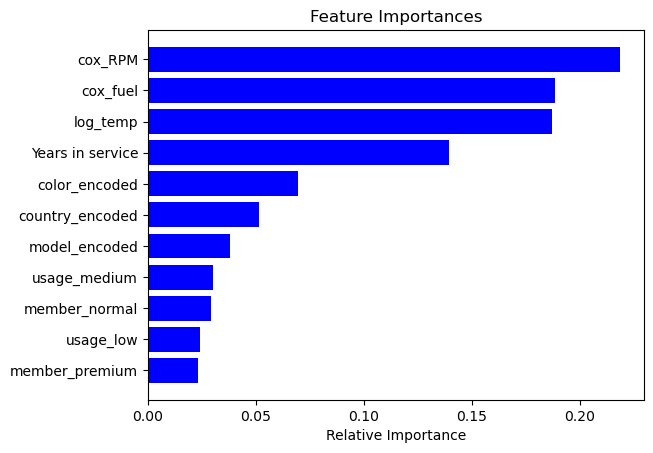

In [663]:
importances = best_models[best_index].feature_importances_
indices = np.argsort(importances)

plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

We can see that `cox_RPM`, in the best model `Decision Tree`, has a significant feature importance of more than 50% of the rest of the variables. We can also infer that the relative RPM, which is an indicator of engine performance given that it represents a 30-day average of max torque speed at max torque, across vehicles indicate a high confidence of failure potential.

The years of service that the car has been put through is second in importance, given it signals wear and tear in the vehicle.

We can also opt to drop `usage_*` and `member_*` variables since they do not contribute much to 

In [631]:
newX = equal_failure_X.loc[:, ~equal_failure_X.columns.isin(['usage_medium', 'usage_low','member_premium', 'member_normal'])]
newX

,Years in service,model_encoded,color_encoded,country_encoded,cox_fuel,log_temp,cox_RPM
1,1,0,0,0,0.675108,4.704110,-0.803255
3,1,0,0,1,-0.917937,4.704110,-0.574573
4,1,0,4,2,-0.152783,4.704009,-0.803255
18,3,2,0,0,2.279335,4.705920,-1.937330
24,5,1,4,2,0.152517,4.706021,0.372551
...,...,...,...,...,...,...,...
9723,8,0,4,0,-0.512200,4.705920,0.595812
9816,9,1,4,0,1.154757,4.704110,1.181921
9824,11,0,4,2,-0.211086,4.704513,-0.007989
9927,4,0,4,1,-0.177297,4.704110,0.118618


In [632]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

best_models, best_params, X_train, y_train, classifiers = gridSearchForBestModel(skf, newX, equal_failure_y, models)

revised_cv_scores = []
revised_cv_stds = []

# find the best model through the cross_val_score
for model in best_models:
    cv_score = cross_val_score(model, X_train, y_train, scoring='f1_macro', cv=5)
    revised_cv_scores.append(cv_score.mean())
    revised_cv_stds.append(cv_score.std())

best_index = revised_cv_scores.index(max(cv_scores))
best_model = best_models[best_index]

print(best_index, best_model)

pd.DataFrame({'CV Mean':revised_cv_scores,'Std':revised_cv_stds},index=classifiers)

Running Logistic Regression
Fitting 5 folds for each of 54 candidates, totalling 270 fits
Running Decision Tree
Fitting 5 folds for each of 60 candidates, totalling 300 fits
Running Random Forest
Fitting 5 folds for each of 60 candidates, totalling 300 fits
Running Naive Bayes, Bernoulli
Fitting 5 folds for each of 6 candidates, totalling 30 fits
Running Linear Support Vector Classification
Fitting 5 folds for each of 12 candidates, totalling 60 fits


/Users/wongshennan/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/wongshennan/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/wongshennan/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/wongshennan/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/wongshennan/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/wongshennan/opt/anaconda3/lib/python3.9/sit

/Users/wongshennan/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/wongshennan/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/wongshennan/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/wongshennan/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/wongshennan/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/wongshennan/opt/anaconda3/lib/python3.9/sit

Running K-Nearest Neighbors
Fitting 5 folds for each of 32 candidates, totalling 160 fits
Running Logistic Regression
Fitting 5 folds for each of 54 candidates, totalling 270 fits
Running Decision Tree
Fitting 5 folds for each of 60 candidates, totalling 300 fits
Running Random Forest
Fitting 5 folds for each of 60 candidates, totalling 300 fits
Running Naive Bayes, Bernoulli
Fitting 5 folds for each of 6 candidates, totalling 30 fits
Running Linear Support Vector Classification
Fitting 5 folds for each of 12 candidates, totalling 60 fits


/Users/wongshennan/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/wongshennan/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/wongshennan/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/wongshennan/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/wongshennan/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/wongshennan/opt/anaconda3/lib/python3.9/sit

/Users/wongshennan/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/wongshennan/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/wongshennan/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/wongshennan/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/wongshennan/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/wongshennan/opt/anaconda3/lib/python3.9/sit

Running K-Nearest Neighbors
Fitting 5 folds for each of 32 candidates, totalling 160 fits
Running Logistic Regression
Fitting 5 folds for each of 54 candidates, totalling 270 fits
Running Decision Tree
Fitting 5 folds for each of 60 candidates, totalling 300 fits
Running Random Forest
Fitting 5 folds for each of 60 candidates, totalling 300 fits
Running Naive Bayes, Bernoulli
Fitting 5 folds for each of 6 candidates, totalling 30 fits
Running Linear Support Vector Classification
Fitting 5 folds for each of 12 candidates, totalling 60 fits


/Users/wongshennan/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/wongshennan/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/wongshennan/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/wongshennan/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/wongshennan/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/wongshennan/opt/anaconda3/lib/python3.9/sit

/Users/wongshennan/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/wongshennan/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/wongshennan/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/wongshennan/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/wongshennan/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/wongshennan/opt/anaconda3/lib/python3.9/sit

Running K-Nearest Neighbors
Fitting 5 folds for each of 32 candidates, totalling 160 fits
Running Logistic Regression
Fitting 5 folds for each of 54 candidates, totalling 270 fits
Running Decision Tree
Fitting 5 folds for each of 60 candidates, totalling 300 fits
Running Random Forest
Fitting 5 folds for each of 60 candidates, totalling 300 fits
Running Naive Bayes, Bernoulli
Fitting 5 folds for each of 6 candidates, totalling 30 fits
Running Linear Support Vector Classification
Fitting 5 folds for each of 12 candidates, totalling 60 fits


/Users/wongshennan/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/wongshennan/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/wongshennan/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/wongshennan/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/wongshennan/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/wongshennan/opt/anaconda3/lib/python3.9/sit

/Users/wongshennan/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/wongshennan/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/wongshennan/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/wongshennan/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/wongshennan/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/wongshennan/opt/anaconda3/lib/python3.9/sit

Running K-Nearest Neighbors
Fitting 5 folds for each of 32 candidates, totalling 160 fits
Running Logistic Regression
Fitting 5 folds for each of 54 candidates, totalling 270 fits
Running Decision Tree
Fitting 5 folds for each of 60 candidates, totalling 300 fits
Running Random Forest
Fitting 5 folds for each of 60 candidates, totalling 300 fits
Running Naive Bayes, Bernoulli
Fitting 5 folds for each of 6 candidates, totalling 30 fits
Running Linear Support Vector Classification
Fitting 5 folds for each of 12 candidates, totalling 60 fits


/Users/wongshennan/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/wongshennan/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/wongshennan/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/wongshennan/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/wongshennan/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/wongshennan/opt/anaconda3/lib/python3.9/sit

/Users/wongshennan/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/wongshennan/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/wongshennan/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/wongshennan/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/wongshennan/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/wongshennan/opt/anaconda3/lib/python3.9/sit

Running K-Nearest Neighbors
Fitting 5 folds for each of 32 candidates, totalling 160 fits
8 RandomForestClassifier(max_depth=50)


,CV Mean,Std
Logistic Regression,0.217535,0.028957
Decision Tree,0.206869,0.022691
Random Forest,0.212932,0.038148
"Naive Bayes, Bernoulli",0.172099,0.011144
Linear Support Vector Classification,0.215642,0.027753
K-Nearest Neighbors,0.205230,0.029258
Logistic Regression,0.219231,0.027105
Decision Tree,0.204933,0.056875
Random Forest,0.222360,0.034261
"Naive Bayes, Bernoulli",0.172099,0.011144


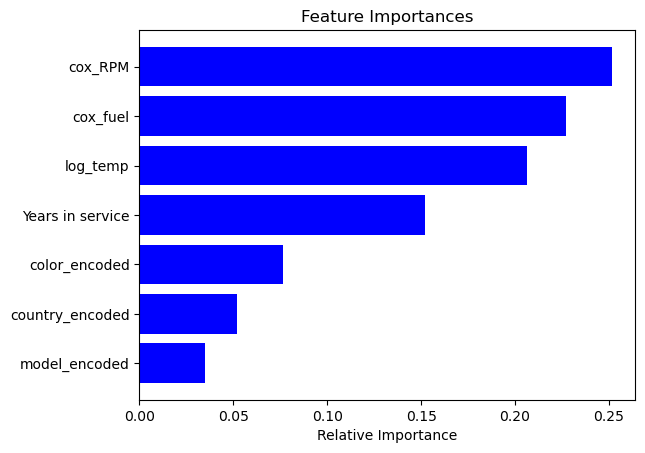

In [633]:
importances = best_model.feature_importances_
indices = np.argsort(importances)
new_features = [feature for feature in newX.columns.to_list()]

plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [new_features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

### Confusion Matrix

In [664]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score
from sklearn.model_selection import cross_val_predict

accuracies = []
conf_matrices = []

best_choice = best_models[best_index]
print(best_choice)

actual = []
predicted = []

for train_index, test_index in skf.split(equal_failure_X):
    _, X_test = equal_failure_X.iloc[train_index], equal_failure_X.iloc[test_index]
    _, y_test = equal_failure_y.iloc[train_index], equal_failure_y.iloc[test_index]
    
    y_pred = best_choice.predict(X_test)

    # evaluate the model's performance
    acc = accuracy_score(y_test, y_pred)
    accuracies.append(acc)
    print(f'Accuracy: {acc:.2f}')

    print(classification_report(y_test, y_pred))

    conf_matrix = confusion_matrix(y_test, y_pred)
    conf_matrix = np.delete(conf_matrix, -1, 0)
    conf_matrix = np.delete(conf_matrix, -1, axis=1)
    conf_matrices.append(conf_matrix)


RandomForestClassifier(max_depth=30, min_samples_split=4)
Accuracy: 1.00
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        56
           1       1.00      1.00      1.00        39
           2       0.98      1.00      0.99        59
           3       1.00      1.00      1.00        42
           4       1.00      0.98      0.99        60
           5       1.00      1.00      1.00        47

    accuracy                           1.00       303
   macro avg       1.00      1.00      1.00       303
weighted avg       1.00      1.00      1.00       303

Accuracy: 0.32
              precision    recall  f1-score   support

           0       0.26      0.27      0.27        51
           1       0.17      0.14      0.16        35
           2       0.38      0.41      0.40        56
           3       0.28      0.18      0.22        60
           4       0.35      0.35      0.35        52
           5       0.39      0.55      0.45 

In [635]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score
from sklearn.model_selection import cross_val_predict

accuracies = []
conf_matrices = []

best_choice = best_models[best_index]
print(best_choice)

actual = []
predicted = []

for train_index, test_index in skf.split(newX):
    _, X_test = newX.iloc[train_index], newX.iloc[test_index]
    _, y_test = equal_failure_y.iloc[train_index], equal_failure_y.iloc[test_index]
    
    y_pred = best_choice.predict(X_test)

    # evaluate the model's performance
    acc = accuracy_score(y_test, y_pred)
    accuracies.append(acc)
    print(f'Accuracy: {acc:.2f}')

    print(classification_report(y_test, y_pred))

    conf_matrix = confusion_matrix(y_test, y_pred)
    conf_matrix = np.delete(conf_matrix, -1, 0)
    conf_matrix = np.delete(conf_matrix, -1, axis=1)
    conf_matrices.append(conf_matrix)


RandomForestClassifier(max_depth=50)
Accuracy: 1.00
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        56
           1       1.00      1.00      1.00        39
           2       1.00      1.00      1.00        59
           3       1.00      1.00      1.00        42
           4       1.00      1.00      1.00        60
           5       1.00      1.00      1.00        47

    accuracy                           1.00       303
   macro avg       1.00      1.00      1.00       303
weighted avg       1.00      1.00      1.00       303

Accuracy: 0.29
              precision    recall  f1-score   support

           0       0.29      0.29      0.29        51
           1       0.21      0.20      0.21        35
           2       0.44      0.54      0.48        56
           3       0.23      0.15      0.18        60
           4       0.33      0.33      0.33        52
           5       0.15      0.18      0.17        49

    accura

The model provides us with a high accuracy of ~88%

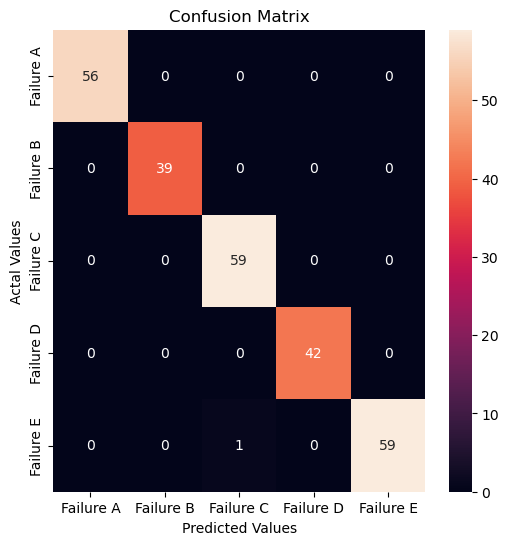

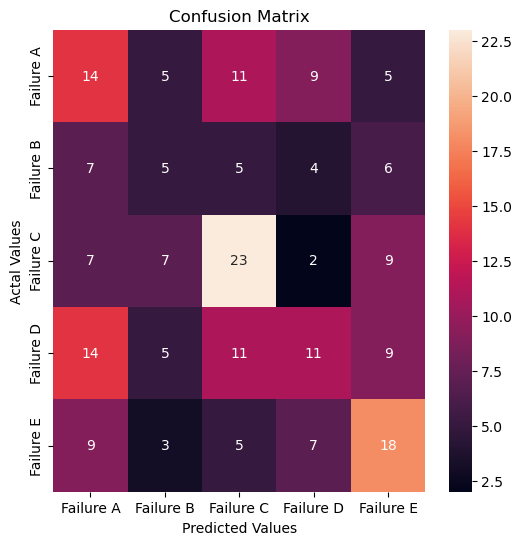

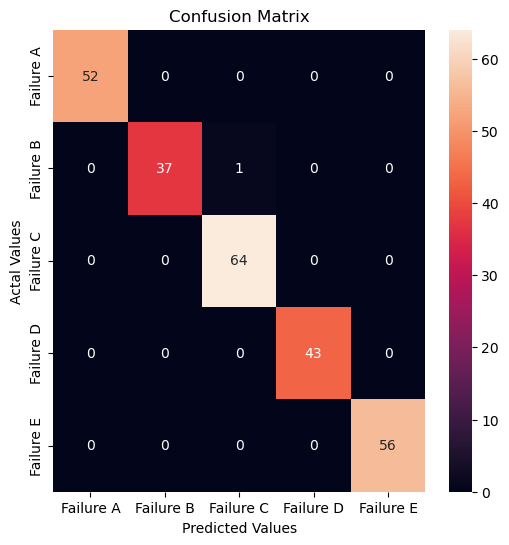

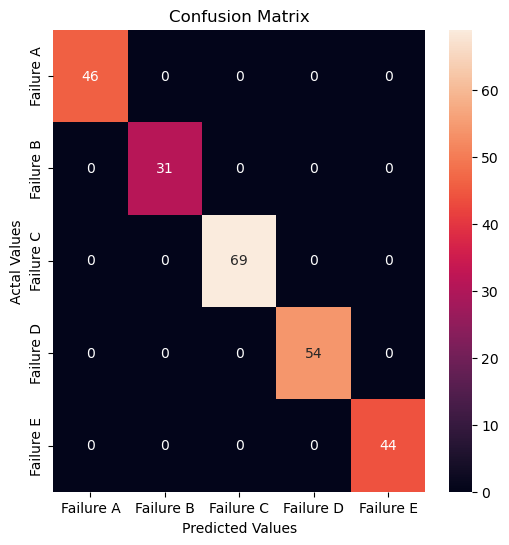

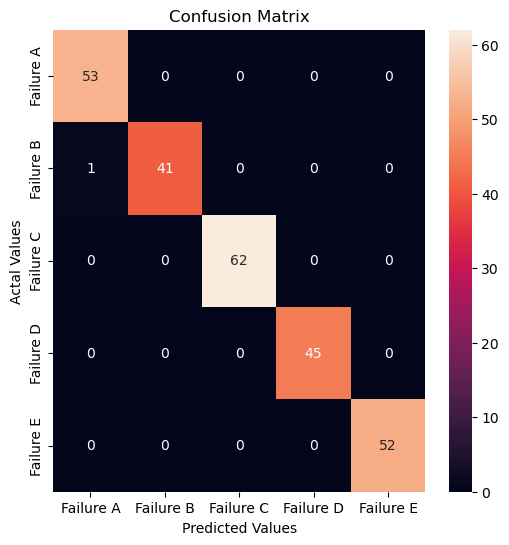

In [665]:
for conf_matrix in conf_matrices:
    cm_df = pd.DataFrame(conf_matrix,
                     index = failure_list, 
                     columns = failure_list)
    
    #Plotting the confusion matrix
    plt.figure(figsize=(6,6))
    sns.heatmap(cm_df, annot=True)
    plt.title('Confusion Matrix')
    plt.ylabel('Actal Values')
    plt.xlabel('Predicted Values')
    plt.show()

# Summary

After a thorough data-exploration, we cleaned understood the relative feature importance of each feature. We also had a deeper understanding of the correlations between various datasets, as cross-examining various feature relationships gave us new insights into the dataset.

While pre-processing the data, we discretized continuous variables, imputed missing values and generated combined feature "BMI" that can more generically explain the relationship between obesity and survival rates.

Using various classification models, we found out that Random Forests provided us with great reliability and accuracy in predicting survival by assessing the importance of each feature and then optimizing the hyperparameters.